# Setup notebook

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

seed = 34
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")
BATCH_SIZE = 64

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


# Load data and augmentation

In [ ]:
training_data = np.load("/kaggle/input/datasetlomi/training_set_no_outliers.npz")
test_data = np.load("/kaggle/input/datasetlomi/test_set.npz")
images = training_data["images"]/255
labels = training_data["labels"]
print(images.shape)

(2270, 64, 128)


**Data augmentation / Manipulation**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2)

In [ ]:
def add_channel(image, label):
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)
    return image, label

In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    flip_prob = tf.random.uniform([], seed=seed)

    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    return image, label

In [ ]:
def to_datasett(X_train, y_train, augmentation = False, seed = seed, shuffle = True, batch_size = BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    ## add the channel
    dataset = dataset.map(
                    lambda x, y: add_channel(x, y),
                    num_parallel_calls=tf.data.AUTOTUNE
                   )

    if augmentation:
          dataset = dataset.map(
                    lambda x, y: random_flip(x, y, seed=seed),
                    num_parallel_calls=tf.data.AUTOTUNE
                   )

    if augmentation:
        dataset = dataset.map(
                        lambda x, y: (tf.squeeze(x, axis=-1), tf.squeeze(y, axis=-1)),
                        num_parallel_calls=tf.data.AUTOTUNE
                    )
    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_dataset = to_datasett(X_train, y_train, augmentation = True)
val_dataset = to_datasett(X_val, y_val, augmentation = False)

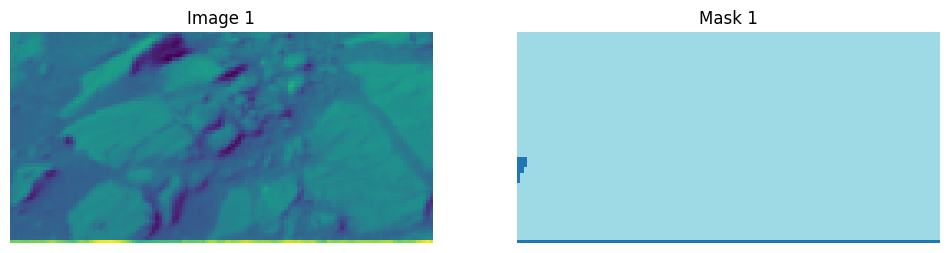

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(1)):
    plt.figure(figsize=(12, 6))

    # Immagine originale
    plt.subplot(1, 2, 1)
    plt.imshow(image[0].numpy())
    plt.title(f"Image {i+1}")
    plt.axis('off')

    # Maschera
    plt.subplot(1, 2, 2)
    plt.imshow(label[0].numpy(), cmap='tab20')  # Usa una colormap per visualizzare le classi
    plt.title(f"Mask {i+1}")
    plt.axis('off')

    plt.show()

# Model

In [ ]:
num_classes = 5
epoch = 1000
patience = 40

In [ ]:
def efficient_skip_connection(skip_tensor, target_channels, name):
    # Apply 1x1 convolution to adjust the number of channels while preserving spatial dimensions
    x = tfkl.Conv2D(
        target_channels,  # Number of output channels
        kernel_size=1,    # 1x1 kernel for efficient channel adjustment
        padding='same',   # Preserve spatial dimensions
        activation='relu', # ReLU activation function
        name=name + '_conv1x1'  # Name for the layer
    )(skip_tensor)
    return x

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    x = input_tensor
    for i in range(stack):
        # Apply a 2D convolution with specified filters and kernel size
        x = tfkl.Conv2D(
            filters,                 # Number of filters
            kernel_size=kernel_size, # Size of the convolution kernel
            padding='same',          # Keep spatial dimensions the same
            name=f"{name}_conv{i+1}" # Name the layer for tracking
        )(x)

        # Add batch normalization to stabilize and accelerate training
        x = tfkl.BatchNormalization(name=f"{name}_bn{i+1}")(x)

        # Apply the specified activation function
        x = tfkl.Activation(
            activation,              # Activation function (e.g., ReLU)
            name=f"{name}_activation{i+1}" # Name the activation layer
        )(x)

    return x



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model


def unetpp_block(inputs, filters, name):
    """
    Crea un nodo della U-Net++ che combina input provenienti da diversi livelli.
    """
    if len(inputs) > 1:
        x = tfkl.Concatenate(name=f"{name}_concat")(inputs)
    else:
        x = inputs[0]

    x = tfkl.Conv2D(filters, kernel_size=3, padding="same", activation="relu", name=f"{name}_conv1")(x)
    x = tfkl.BatchNormalization(name=f"{name}_bn1")(x)
    x = tfkl.Conv2D(filters, kernel_size=3, padding="same", activation="relu", name=f"{name}_conv2")(x)
    x = tfkl.BatchNormalization(name=f"{name}_bn2")(x)
    return x


def get_unetpp(input_shape=(64, 128, 1), num_classes=5, filters=[32, 64, 128, 256, 512], seed=42):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Downsampling path
    x00 = unetpp_block([input_layer], filters[0], name="x00")
    d0 = tfkl.MaxPooling2D(pool_size=(2, 2))(x00)

    x10 = unetpp_block([d0], filters[1], name="x10")
    d1 = tfkl.MaxPooling2D(pool_size=(2, 2))(x10)

    x20 = unetpp_block([d1], filters[2], name="x20")
    d2 = tfkl.MaxPooling2D(pool_size=(2, 2))(x20)

    x30 = unetpp_block([d2], filters[3], name="x30")
    d3 = tfkl.MaxPooling2D(pool_size=(2, 2))(x30)

    x40 = unetpp_block([d3], filters[4], name="x40")

    # Upsampling path with dense connections
    x01 = unetpp_block([x00, tfkl.UpSampling2D(size=(2, 2))(x10)], filters[0], name="x01")
    x11 = unetpp_block([x10, tfkl.UpSampling2D(size=(2, 2))(x20)], filters[1], name="x11")
    x02 = unetpp_block([x01, tfkl.UpSampling2D(size=(2, 2))(x11)], filters[0], name="x02")

    x21 = unetpp_block([x20, tfkl.UpSampling2D(size=(2, 2))(x30)], filters[2], name="x21")
    x12 = unetpp_block([x11, tfkl.UpSampling2D(size=(2, 2))(x21)], filters[1], name="x12")
    x03 = unetpp_block([x02, tfkl.UpSampling2D(size=(2, 2))(x12)], filters[0], name="x03")

    x31 = unetpp_block([x30, tfkl.UpSampling2D(size=(2, 2))(x40)], filters[3], name="x31")
    x22 = unetpp_block([x21, tfkl.UpSampling2D(size=(2, 2))(x31)], filters[2], name="x22")
    x13 = unetpp_block([x12, tfkl.UpSampling2D(size=(2, 2))(x22)], filters[1], name="x13")
    x04 = unetpp_block([x03, tfkl.UpSampling2D(size=(2, 2))(x13)], filters[0], name="x04")

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, activation="softmax", name="output_layer")(x04)

    model = Model(inputs=input_layer, outputs=output_layer, name="UNetPlusPlus")
    return model


Model: "UNetPlusPlus"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x00_conv1         │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x00_bn1           │ (None, 64, 128, │       128 │ x00_conv1[0][… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x00_conv2         │ (None, 64, 128, │     9,248 │ x00_bn1[0][0]  │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x00_bn2           │ (None, 64, 128, │       128 │ x00_conv2[0][… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_4   │ (None, 32, 64,  │         0 │ x00_bn2[0][0]  │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x10_conv1         │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x10_bn1           │ (None, 32, 64,  │       256 │ x10_conv1[0][… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x10_conv2         │ (None, 32, 64,  │    36,928 │ x10_bn1[0][0]  │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x10_bn2           │ (None, 32, 64,  │       256 │ x10_conv2[0][… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_5   │ (None, 16, 32,  │         0 │ x10_bn2[0][0]  │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x20_conv1         │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x20_bn1           │ (None, 16, 32,  │       512 │ x20_conv1[0][… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x20_conv2         │ (None, 16, 32,  │   147,584 │ x20_bn1[0][0]  │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x20_bn2           │ (None, 16, 32,  │       512 │ x20_conv2[0][… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_6   │ (None, 8, 16,   │         0 │ x20_bn2[0][0]  │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ x30_conv1         │ (None, 8, 16,   │   295,168 │ max_pooling2d… │   Y 

 Total params: 8,856,837 (33.79 MB)

 Trainable params: 8,849,541 (33.76 MB)

 Non-trainable params: 7,296 (28.50 KB)

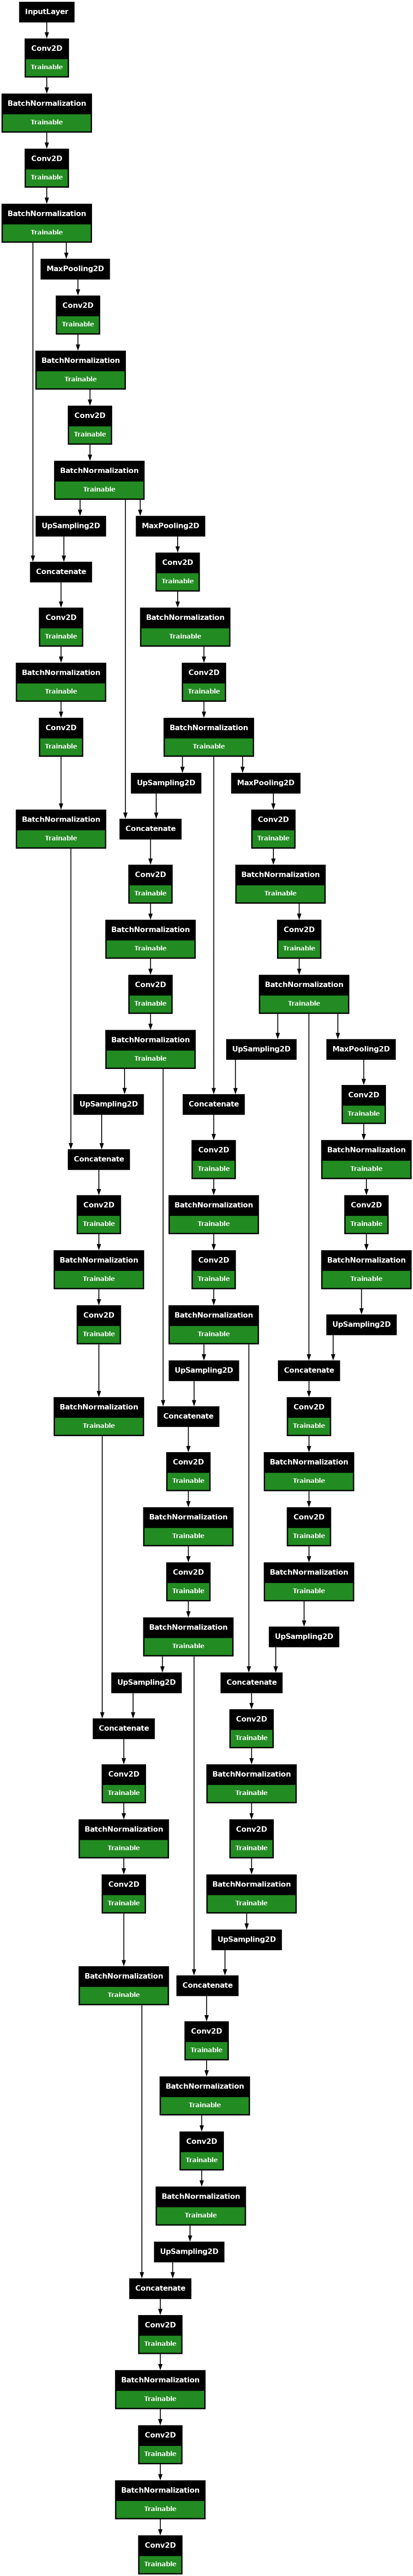

In [ ]:
model = get_unetpp()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

# Mean intersection over union

In [ ]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=[0], name="mean_iou", dtype=None, **kwargs):
        """
        Aggiunto **kwargs per gestire parametri inattesi come `ignore_class`.
        """
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        return super().update_state(y_true, y_pred, sample_weight)

# Registra la classe personalizzata
tf.keras.utils.get_custom_objects()["MeanIntersectionOverUnion"] = MeanIntersectionOverUnion


# Visualization

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored



In [ ]:
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, frequency=5, num_classes=2):
        super().__init__()
        self.dataset = dataset
        self.frequency = frequency
        self.num_classes = num_classes
        self.dataset_iter = iter(dataset)  # Crea un iteratore per accedere ai dati

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epochs
            try:
                # Estrai un batch di dati
                image, label = next(self.dataset_iter)
            except StopIteration:
                # Ricrea l'iteratore se i dati sono terminati
                self.dataset_iter = iter(self.dataset)
                image, label = next(self.dataset_iter)

            # Prepara i dati per la predizione
            image = tf.expand_dims(image[0], 0)  # Estrai una sola immagine dal batch
            label = label[0]  # Etichetta corrispondente
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Creazione della mappa colori
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Immagine di input
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predizione
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()



# Compilation and training

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(0.001),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

viz_callback = VizCallback(val_dataset, frequency=5, num_classes=5)

Epoch 1/1000


W0000 00:00:1733052806.438760      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3963 - loss: 1.5680 - mean_iou: 0.1905

W0000 00:00:1733052821.253328      94 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.3994 - loss: 1.5606 - mean_iou: 0.1925

W0000 00:00:1733052834.449377      91 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733052836.799372      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


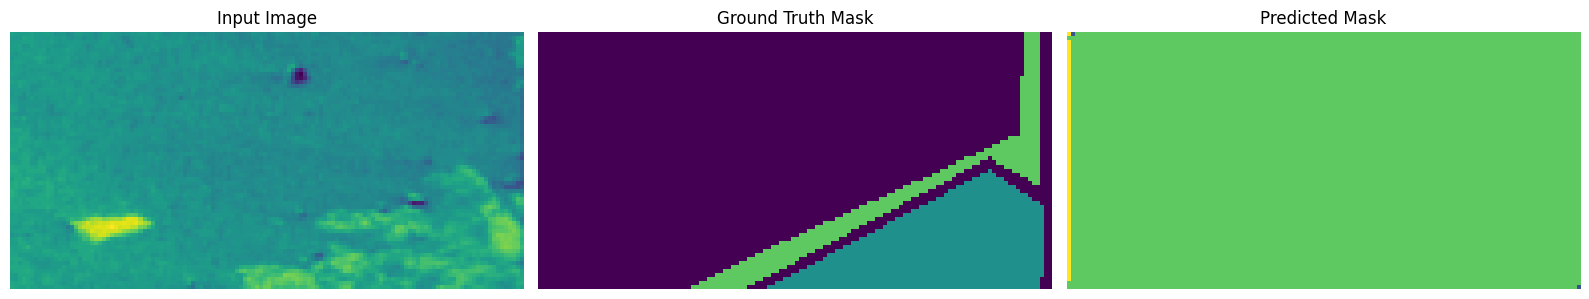

29/29 ━━━━━━━━━━━━━━━━━━━━ 57s 930ms/step - accuracy: 0.4024 - loss: 1.5537 - mean_iou: 0.1944 - val_accuracy: 0.1935 - val_loss: 38.5369 - val_mean_iou: 0.0666
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.5800 - loss: 1.1724 - mean_iou: 0.3112 - val_accuracy: 0.1937 - val_loss: 22.4221 - val_mean_iou: 0.0667
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.6210 - loss: 1.0498 - mean_iou: 0.3433 - val_accuracy: 0.1937 - val_loss: 17.2920 - val_mean_iou: 0.0665
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.6398 - loss: 0.9688 - mean_iou: 0.3722 - val_accuracy: 0.1947 - val_loss: 9.5012 - val_mean_iou: 0.0664
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.6516 - loss: 0.9458 - mean_iou: 0.3687 - val_accuracy: 0.2023 - val_loss: 8.7452 - val_mean_iou: 0.0745
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6817 - loss: 0.8673 - mean_iou: 0.3940

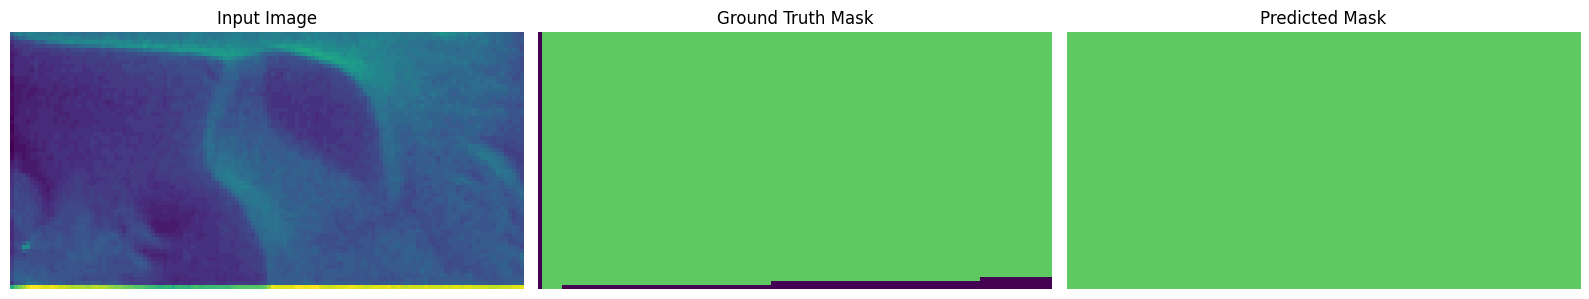

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.6817 - loss: 0.8673 - mean_iou: 0.3941 - val_accuracy: 0.1947 - val_loss: 9.0184 - val_mean_iou: 0.0664
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.6871 - loss: 0.8417 - mean_iou: 0.4029 - val_accuracy: 0.1957 - val_loss: 6.9696 - val_mean_iou: 0.0676
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.6918 - loss: 0.8281 - mean_iou: 0.4023 - val_accuracy: 0.1947 - val_loss: 7.3658 - val_mean_iou: 0.0664
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.7005 - loss: 0.8050 - mean_iou: 0.4142 - val_accuracy: 0.2627 - val_loss: 6.2311 - val_mean_iou: 0.1281
Epoch 10/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.6954 - loss: 0.7950 - mean_iou: 0.4098 - val_accuracy: 0.1981 - val_loss: 5.2961 - val_mean_iou: 0.0560
Epoch 11/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7301 - loss: 0.7191 - mean_iou: 0.4438

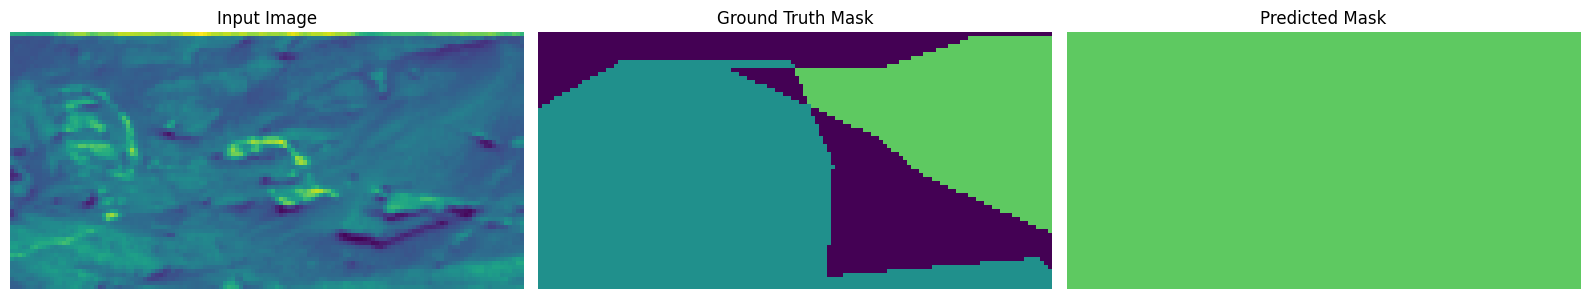

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.7299 - loss: 0.7195 - mean_iou: 0.4435 - val_accuracy: 0.1948 - val_loss: 4.1213 - val_mean_iou: 0.0665
Epoch 12/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.7209 - loss: 0.7356 - mean_iou: 0.4332 - val_accuracy: 0.2038 - val_loss: 4.6235 - val_mean_iou: 0.0608
Epoch 13/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.7322 - loss: 0.7030 - mean_iou: 0.4385 - val_accuracy: 0.1951 - val_loss: 4.3475 - val_mean_iou: 0.0669
Epoch 14/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.7376 - loss: 0.6958 - mean_iou: 0.4455 - val_accuracy: 0.1947 - val_loss: 5.1851 - val_mean_iou: 0.0531
Epoch 15/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.7267 - loss: 0.7251 - mean_iou: 0.4346 - val_accuracy: 0.2776 - val_loss: 3.1538 - val_mean_iou: 0.1179
Epoch 16/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7462 - loss: 0.6652 - mean_iou: 0.4554

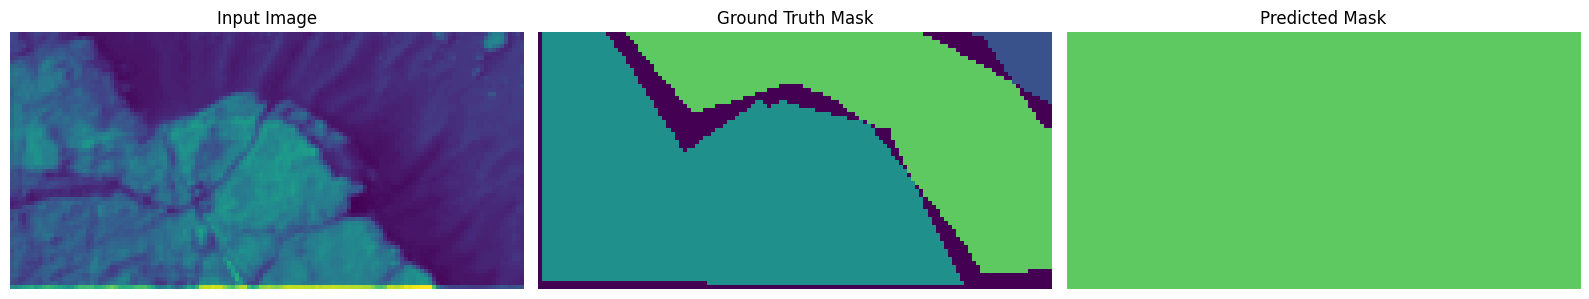

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.7461 - loss: 0.6653 - mean_iou: 0.4552 - val_accuracy: 0.2604 - val_loss: 3.7768 - val_mean_iou: 0.1066
Epoch 17/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.7471 - loss: 0.6655 - mean_iou: 0.4667 - val_accuracy: 0.2792 - val_loss: 3.6312 - val_mean_iou: 0.1172
Epoch 18/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.7404 - loss: 0.6841 - mean_iou: 0.4458 - val_accuracy: 0.3048 - val_loss: 3.4973 - val_mean_iou: 0.1309
Epoch 19/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.7559 - loss: 0.6438 - mean_iou: 0.4654 - val_accuracy: 0.2953 - val_loss: 3.4950 - val_mean_iou: 0.1155
Epoch 20/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.7455 - loss: 0.6623 - mean_iou: 0.4526 - val_accuracy: 0.3305 - val_loss: 2.7311 - val_mean_iou: 0.1438
Epoch 21/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7562 - loss: 0.6300 - mean_iou: 0.4605

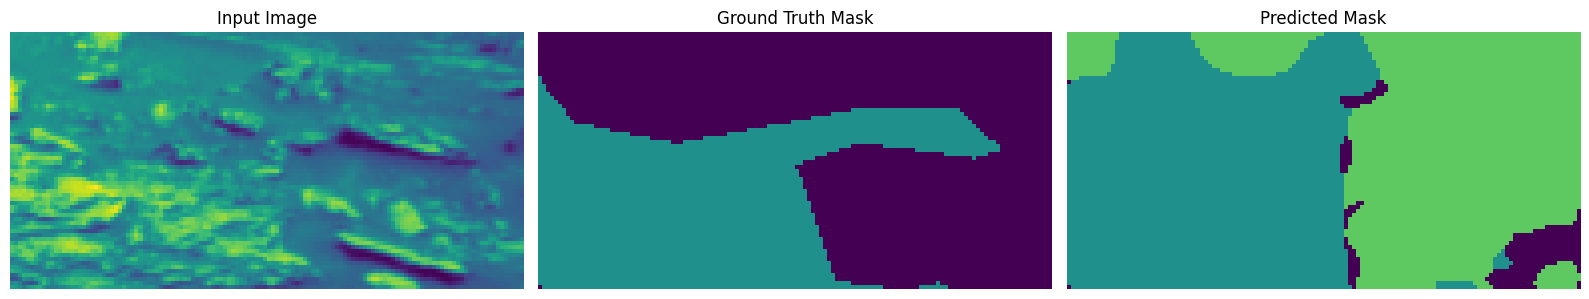

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.7562 - loss: 0.6299 - mean_iou: 0.4605 - val_accuracy: 0.5208 - val_loss: 2.0236 - val_mean_iou: 0.2889
Epoch 22/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.7667 - loss: 0.6082 - mean_iou: 0.4762 - val_accuracy: 0.6147 - val_loss: 1.3076 - val_mean_iou: 0.3679
Epoch 23/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.7558 - loss: 0.6355 - mean_iou: 0.4585 - val_accuracy: 0.5497 - val_loss: 1.4217 - val_mean_iou: 0.2777
Epoch 24/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.7793 - loss: 0.5769 - mean_iou: 0.4872 - val_accuracy: 0.5510 - val_loss: 1.6226 - val_mean_iou: 0.2975
Epoch 25/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.7706 - loss: 0.6071 - mean_iou: 0.4732 - val_accuracy: 0.6271 - val_loss: 1.0885 - val_mean_iou: 0.3375
Epoch 26/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7698 - loss: 0.6007 - mean_iou: 0.4776

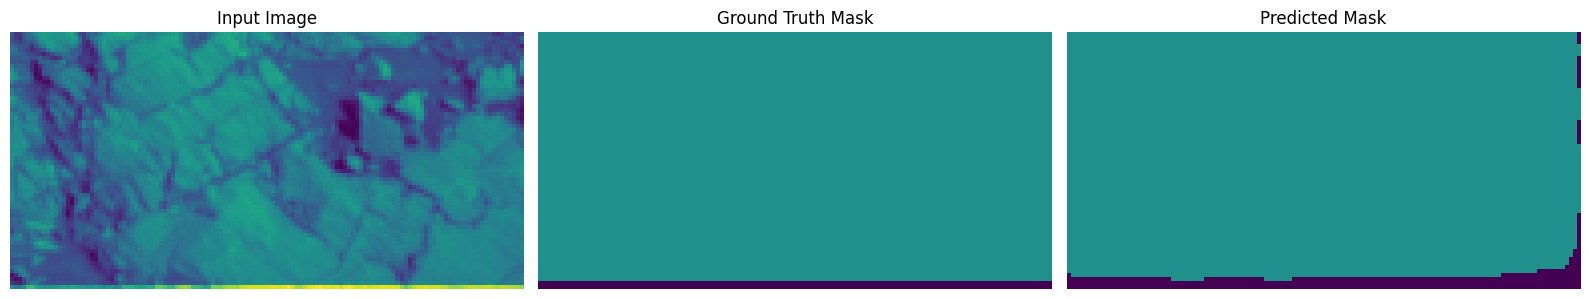

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.7698 - loss: 0.6005 - mean_iou: 0.4775 - val_accuracy: 0.5562 - val_loss: 1.5600 - val_mean_iou: 0.2811
Epoch 27/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.7876 - loss: 0.5531 - mean_iou: 0.4901 - val_accuracy: 0.6844 - val_loss: 0.9703 - val_mean_iou: 0.4104
Epoch 28/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.7790 - loss: 0.5687 - mean_iou: 0.4805 - val_accuracy: 0.5914 - val_loss: 1.2870 - val_mean_iou: 0.3170
Epoch 29/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.7736 - loss: 0.5791 - mean_iou: 0.4729 - val_accuracy: 0.6943 - val_loss: 0.8752 - val_mean_iou: 0.4358
Epoch 30/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.7817 - loss: 0.5668 - mean_iou: 0.4785 - val_accuracy: 0.6931 - val_loss: 0.8313 - val_mean_iou: 0.4198
Epoch 31/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7998 - loss: 0.5128 - mean_iou: 0.4953

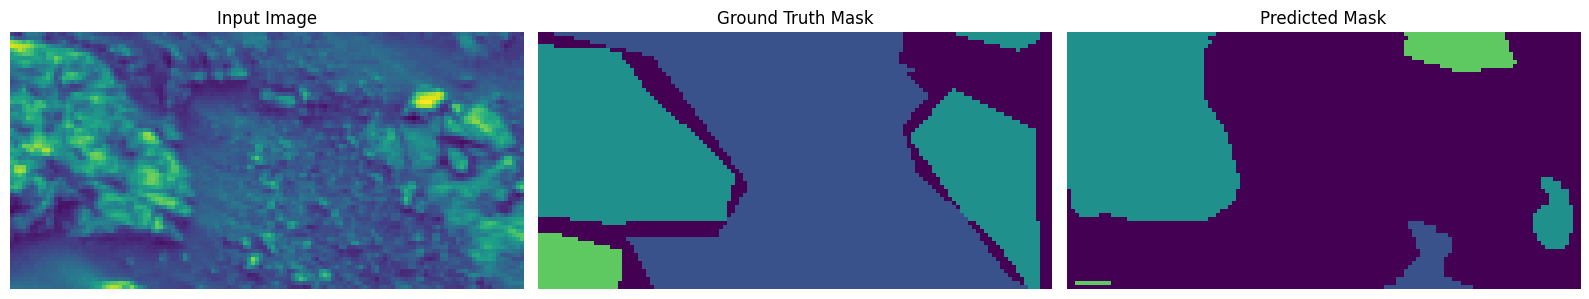

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.7993 - loss: 0.5137 - mean_iou: 0.4949 - val_accuracy: 0.6416 - val_loss: 1.0676 - val_mean_iou: 0.3685
Epoch 32/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.7967 - loss: 0.5231 - mean_iou: 0.4997 - val_accuracy: 0.5965 - val_loss: 1.2876 - val_mean_iou: 0.3163
Epoch 33/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.8098 - loss: 0.4966 - mean_iou: 0.5071 - val_accuracy: 0.6794 - val_loss: 0.8285 - val_mean_iou: 0.4129
Epoch 34/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.8102 - loss: 0.4926 - mean_iou: 0.5056 - val_accuracy: 0.6586 - val_loss: 0.9912 - val_mean_iou: 0.3912
Epoch 35/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8078 - loss: 0.4925 - mean_iou: 0.5085 - val_accuracy: 0.6659 - val_loss: 0.9162 - val_mean_iou: 0.3927
Epoch 36/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8181 - loss: 0.4729 - mean_iou: 0.5121

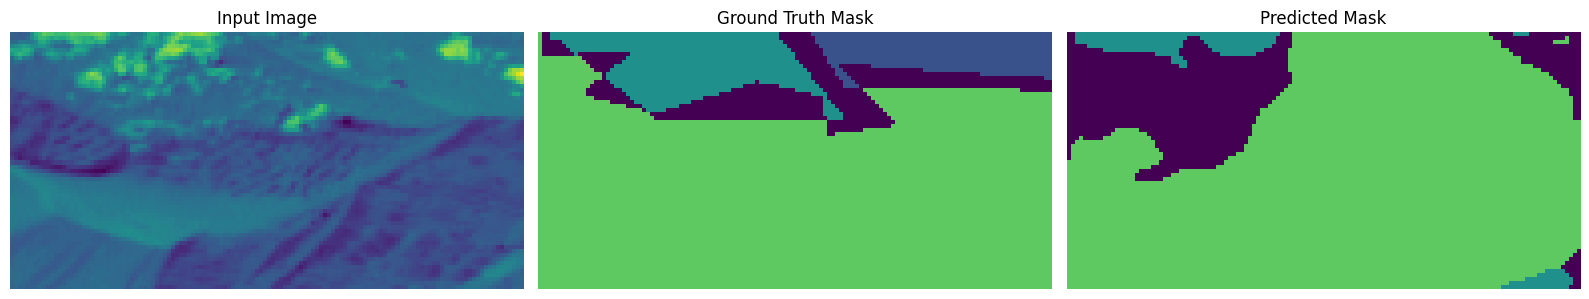

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.8178 - loss: 0.4735 - mean_iou: 0.5119 - val_accuracy: 0.6871 - val_loss: 0.8458 - val_mean_iou: 0.4104
Epoch 37/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8174 - loss: 0.4696 - mean_iou: 0.5158 - val_accuracy: 0.6288 - val_loss: 1.1326 - val_mean_iou: 0.3259
Epoch 38/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8147 - loss: 0.4848 - mean_iou: 0.5143 - val_accuracy: 0.6433 - val_loss: 1.0458 - val_mean_iou: 0.3814
Epoch 39/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.8170 - loss: 0.4774 - mean_iou: 0.5129 - val_accuracy: 0.7213 - val_loss: 0.8515 - val_mean_iou: 0.4389
Epoch 40/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8307 - loss: 0.4369 - mean_iou: 0.5249 - val_accuracy: 0.6777 - val_loss: 0.8454 - val_mean_iou: 0.3858
Epoch 41/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8335 - loss: 0.4388 - mean_iou: 0.5174

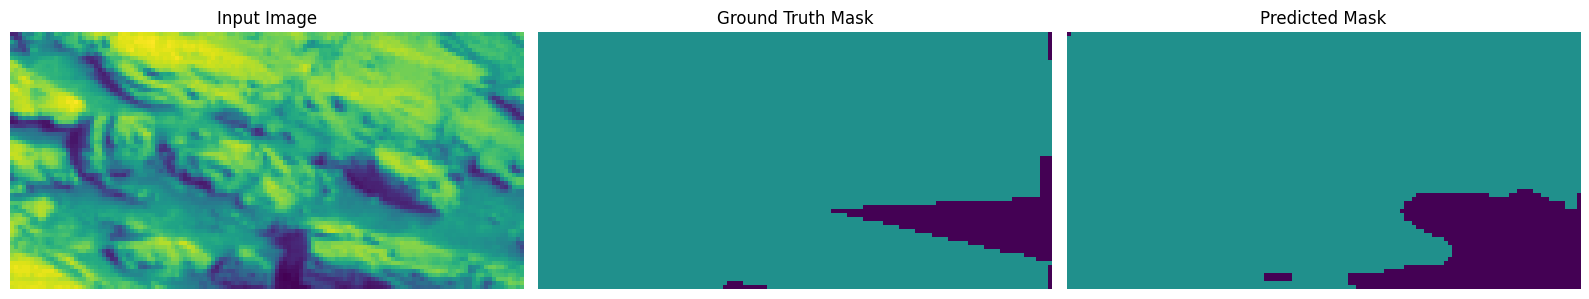

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.8335 - loss: 0.4389 - mean_iou: 0.5175 - val_accuracy: 0.7010 - val_loss: 0.8693 - val_mean_iou: 0.4139
Epoch 42/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8271 - loss: 0.4489 - mean_iou: 0.5125 - val_accuracy: 0.6904 - val_loss: 0.9083 - val_mean_iou: 0.4021
Epoch 43/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.8393 - loss: 0.4198 - mean_iou: 0.5202 - val_accuracy: 0.6476 - val_loss: 1.0517 - val_mean_iou: 0.3504
Epoch 44/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8416 - loss: 0.4132 - mean_iou: 0.5282 - val_accuracy: 0.6446 - val_loss: 1.0439 - val_mean_iou: 0.3491
Epoch 45/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8465 - loss: 0.3981 - mean_iou: 0.5249 - val_accuracy: 0.6166 - val_loss: 1.3170 - val_mean_iou: 0.3167
Epoch 46/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8531 - loss: 0.3866 - mean_iou: 0.5307

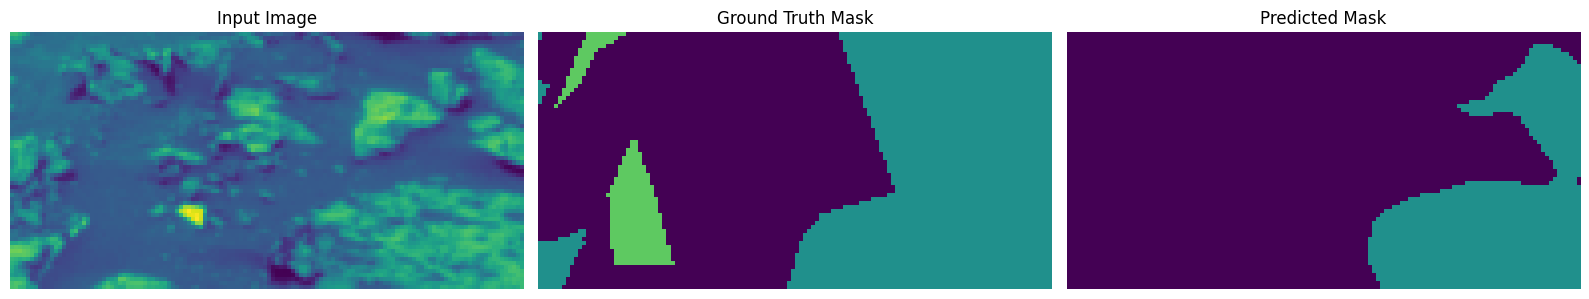

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.8530 - loss: 0.3868 - mean_iou: 0.5306 - val_accuracy: 0.6582 - val_loss: 1.1273 - val_mean_iou: 0.3575
Epoch 47/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8483 - loss: 0.3845 - mean_iou: 0.5310 - val_accuracy: 0.6124 - val_loss: 1.1285 - val_mean_iou: 0.3397
Epoch 48/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.8650 - loss: 0.3537 - mean_iou: 0.5341 - val_accuracy: 0.6740 - val_loss: 1.0521 - val_mean_iou: 0.3925
Epoch 49/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8686 - loss: 0.3438 - mean_iou: 0.5411 - val_accuracy: 0.6596 - val_loss: 0.9791 - val_mean_iou: 0.3648
Epoch 50/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.8610 - loss: 0.3592 - mean_iou: 0.5326 - val_accuracy: 0.7231 - val_loss: 0.8817 - val_mean_iou: 0.4317
Epoch 51/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8599 - loss: 0.3620 - mean_iou: 0.5280

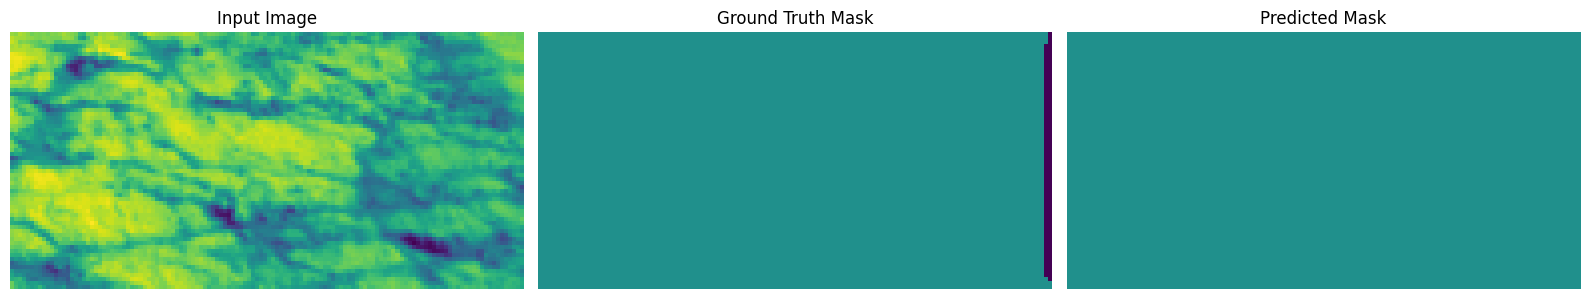

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.8600 - loss: 0.3617 - mean_iou: 0.5281 - val_accuracy: 0.6653 - val_loss: 1.2869 - val_mean_iou: 0.3734
Epoch 52/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8717 - loss: 0.3357 - mean_iou: 0.5393 - val_accuracy: 0.6502 - val_loss: 1.2202 - val_mean_iou: 0.3844
Epoch 53/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8799 - loss: 0.3174 - mean_iou: 0.5463 - val_accuracy: 0.7091 - val_loss: 0.8728 - val_mean_iou: 0.4276
Epoch 54/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8776 - loss: 0.3260 - mean_iou: 0.5391 - val_accuracy: 0.6636 - val_loss: 1.1584 - val_mean_iou: 0.3701
Epoch 55/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.8834 - loss: 0.3108 - mean_iou: 0.5546 - val_accuracy: 0.6801 - val_loss: 0.9881 - val_mean_iou: 0.4083
Epoch 56/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8814 - loss: 0.3140 - mean_iou: 0.5412

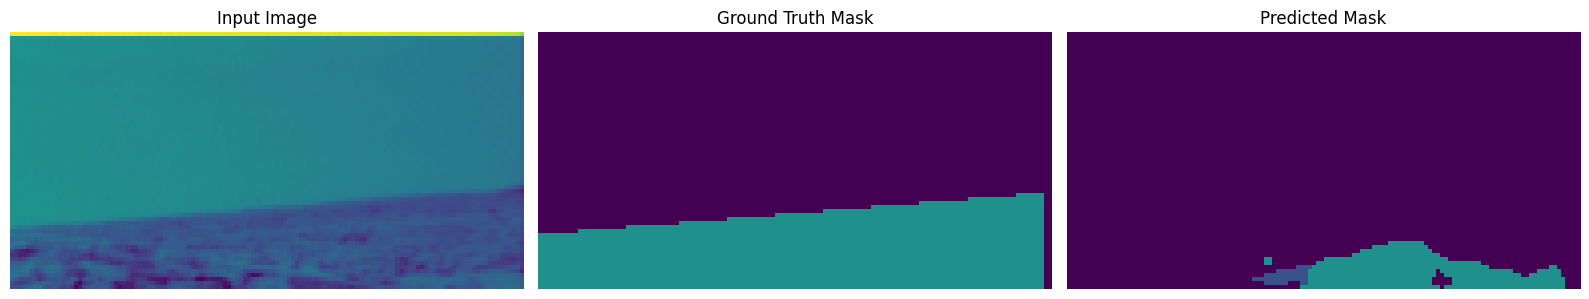

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.8813 - loss: 0.3143 - mean_iou: 0.5409 - val_accuracy: 0.6375 - val_loss: 1.1668 - val_mean_iou: 0.3451
Epoch 57/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8778 - loss: 0.3184 - mean_iou: 0.5551 - val_accuracy: 0.6955 - val_loss: 0.9982 - val_mean_iou: 0.4035
Epoch 58/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8963 - loss: 0.2714 - mean_iou: 0.5538 - val_accuracy: 0.6909 - val_loss: 0.9940 - val_mean_iou: 0.4109
Epoch 59/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.8987 - loss: 0.2695 - mean_iou: 0.5711 - val_accuracy: 0.7274 - val_loss: 0.8944 - val_mean_iou: 0.4403
Epoch 60/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.8998 - loss: 0.2681 - mean_iou: 0.5791 - val_accuracy: 0.7299 - val_loss: 0.9077 - val_mean_iou: 0.4461
Epoch 61/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9073 - loss: 0.2471 - mean_iou: 0.5855

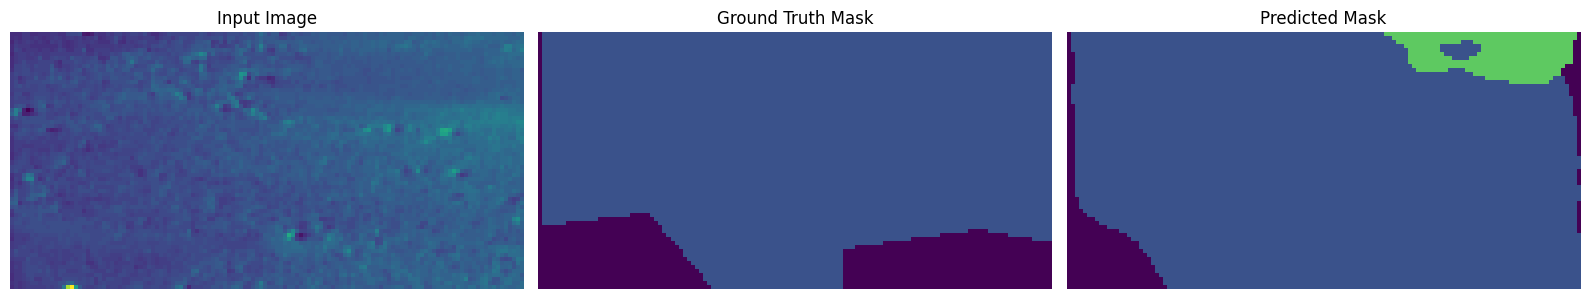

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.9073 - loss: 0.2471 - mean_iou: 0.5852 - val_accuracy: 0.6981 - val_loss: 1.1137 - val_mean_iou: 0.4043
Epoch 62/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9134 - loss: 0.2306 - mean_iou: 0.5843 - val_accuracy: 0.6868 - val_loss: 1.0712 - val_mean_iou: 0.3959
Epoch 63/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.9042 - loss: 0.2550 - mean_iou: 0.5845 - val_accuracy: 0.7364 - val_loss: 0.8554 - val_mean_iou: 0.4788
Epoch 64/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9103 - loss: 0.2387 - mean_iou: 0.6165 - val_accuracy: 0.7251 - val_loss: 0.9509 - val_mean_iou: 0.4503
Epoch 65/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9126 - loss: 0.2352 - mean_iou: 0.6087 - val_accuracy: 0.7185 - val_loss: 0.8976 - val_mean_iou: 0.4397
Epoch 66/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9096 - loss: 0.2404 - mean_iou: 0.6013

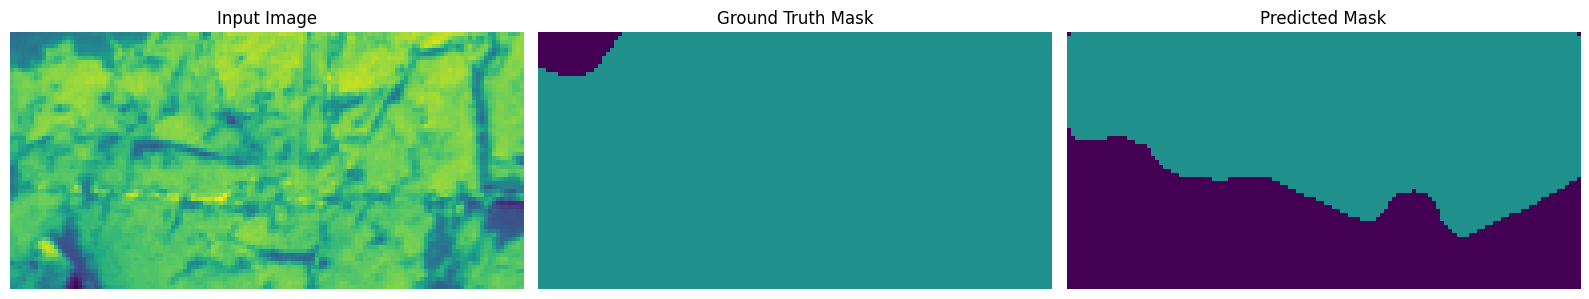

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.9095 - loss: 0.2404 - mean_iou: 0.6010 - val_accuracy: 0.6919 - val_loss: 0.9457 - val_mean_iou: 0.4100
Epoch 67/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9130 - loss: 0.2331 - mean_iou: 0.5908 - val_accuracy: 0.7089 - val_loss: 0.9696 - val_mean_iou: 0.4178
Epoch 68/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9205 - loss: 0.2103 - mean_iou: 0.6230 - val_accuracy: 0.7309 - val_loss: 0.9239 - val_mean_iou: 0.4561
Epoch 69/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9213 - loss: 0.2097 - mean_iou: 0.6274 - val_accuracy: 0.7115 - val_loss: 1.0282 - val_mean_iou: 0.4353
Epoch 70/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9180 - loss: 0.2184 - mean_iou: 0.6057 - val_accuracy: 0.7228 - val_loss: 0.9712 - val_mean_iou: 0.4412
Epoch 71/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9060 - loss: 0.2491 - mean_iou: 0.6161

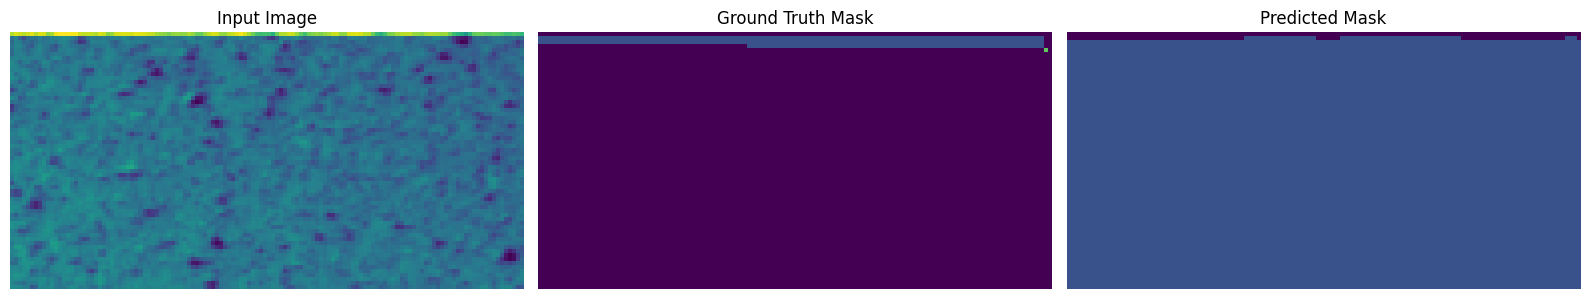

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.9060 - loss: 0.2489 - mean_iou: 0.6154 - val_accuracy: 0.6545 - val_loss: 1.4375 - val_mean_iou: 0.3663
Epoch 72/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9122 - loss: 0.2292 - mean_iou: 0.6190 - val_accuracy: 0.6934 - val_loss: 1.2293 - val_mean_iou: 0.3995
Epoch 73/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9183 - loss: 0.2152 - mean_iou: 0.6367 - val_accuracy: 0.7133 - val_loss: 0.9677 - val_mean_iou: 0.4244
Epoch 74/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9180 - loss: 0.2219 - mean_iou: 0.6062 - val_accuracy: 0.6682 - val_loss: 1.4588 - val_mean_iou: 0.3626
Epoch 75/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9189 - loss: 0.2151 - mean_iou: 0.6069 - val_accuracy: 0.7132 - val_loss: 1.0640 - val_mean_iou: 0.4266
Epoch 76/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9281 - loss: 0.1876 - mean_iou: 0.6382

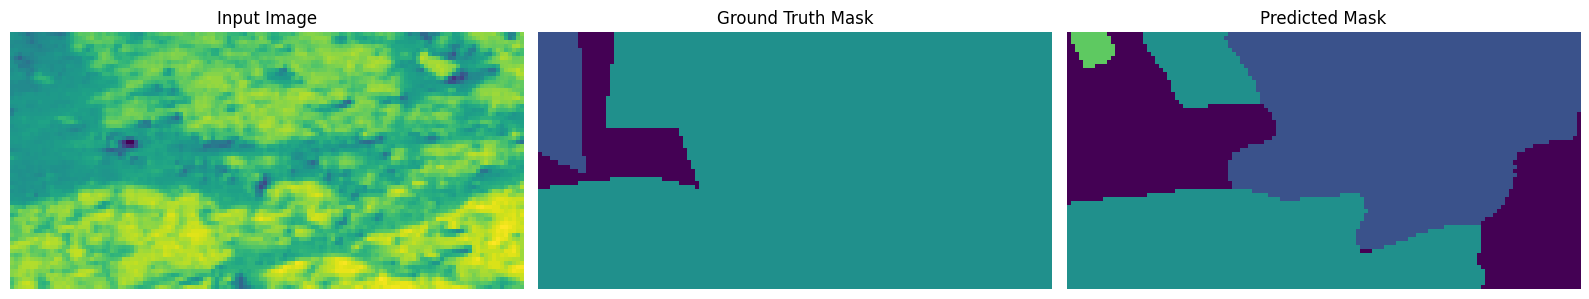

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.9281 - loss: 0.1875 - mean_iou: 0.6382 - val_accuracy: 0.7022 - val_loss: 1.0881 - val_mean_iou: 0.4135
Epoch 77/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9326 - loss: 0.1760 - mean_iou: 0.6389 - val_accuracy: 0.7303 - val_loss: 0.9467 - val_mean_iou: 0.4531
Epoch 78/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9355 - loss: 0.1709 - mean_iou: 0.6591 - val_accuracy: 0.7401 - val_loss: 0.9782 - val_mean_iou: 0.4558
Epoch 79/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9363 - loss: 0.1655 - mean_iou: 0.6550 - val_accuracy: 0.7482 - val_loss: 0.9546 - val_mean_iou: 0.4714
Epoch 80/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9312 - loss: 0.1793 - mean_iou: 0.6165 - val_accuracy: 0.7006 - val_loss: 1.2016 - val_mean_iou: 0.4033
Epoch 81/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9302 - loss: 0.1847 - mean_iou: 0.6626

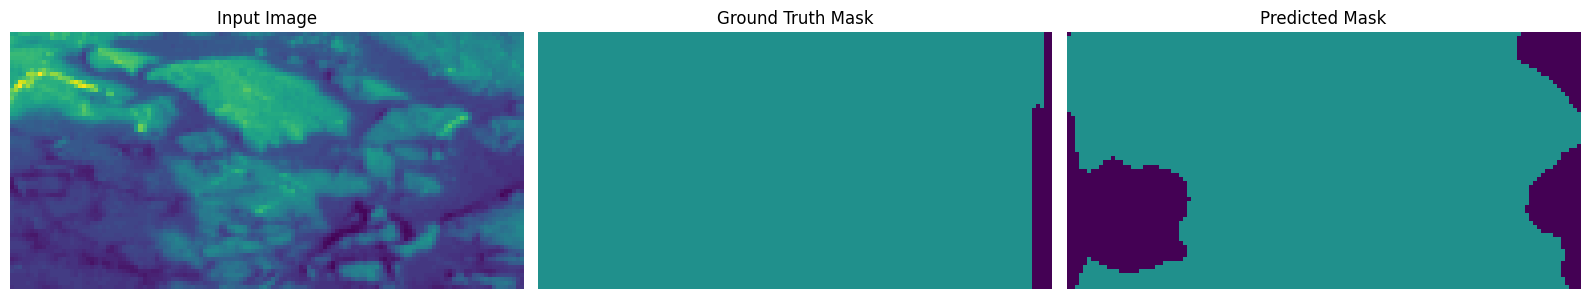

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.9302 - loss: 0.1847 - mean_iou: 0.6621 - val_accuracy: 0.7313 - val_loss: 1.0006 - val_mean_iou: 0.4404
Epoch 82/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9338 - loss: 0.1731 - mean_iou: 0.6596 - val_accuracy: 0.7348 - val_loss: 0.9993 - val_mean_iou: 0.4449
Epoch 83/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.9418 - loss: 0.1479 - mean_iou: 0.6406 - val_accuracy: 0.7496 - val_loss: 0.9159 - val_mean_iou: 0.4710
Epoch 84/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9421 - loss: 0.1469 - mean_iou: 0.6948 - val_accuracy: 0.7228 - val_loss: 1.0357 - val_mean_iou: 0.4326
Epoch 85/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9158 - loss: 0.2602 - mean_iou: 0.6305 - val_accuracy: 0.6985 - val_loss: 1.2240 - val_mean_iou: 0.4334
Epoch 86/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9147 - loss: 0.2353 - mean_iou: 0.6312

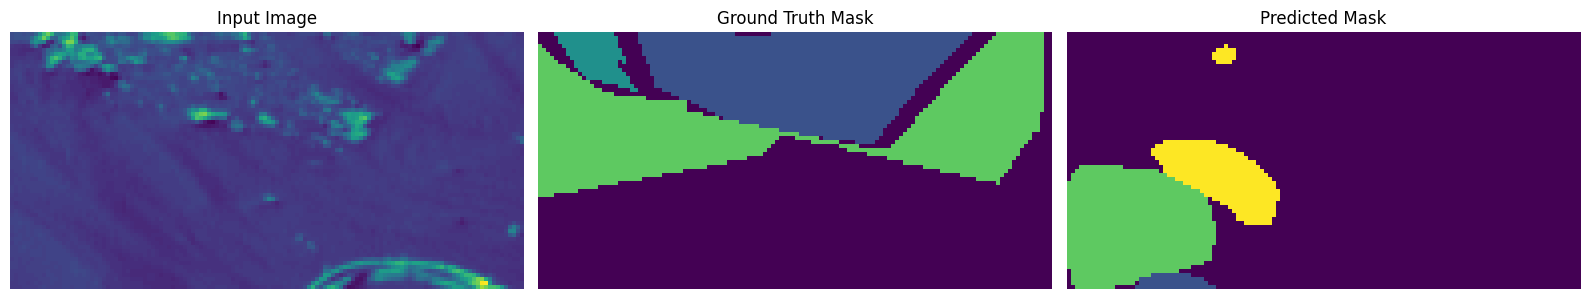

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.9148 - loss: 0.2349 - mean_iou: 0.6314 - val_accuracy: 0.6090 - val_loss: 1.6892 - val_mean_iou: 0.3122
Epoch 87/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9297 - loss: 0.1854 - mean_iou: 0.6525 - val_accuracy: 0.7187 - val_loss: 1.0659 - val_mean_iou: 0.4320
Epoch 88/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9383 - loss: 0.1589 - mean_iou: 0.6848 - val_accuracy: 0.7090 - val_loss: 1.0955 - val_mean_iou: 0.4296
Epoch 89/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9385 - loss: 0.1592 - mean_iou: 0.7000 - val_accuracy: 0.7316 - val_loss: 1.0165 - val_mean_iou: 0.4478
Epoch 90/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9434 - loss: 0.1467 - mean_iou: 0.6904 - val_accuracy: 0.7462 - val_loss: 0.9227 - val_mean_iou: 0.4717
Epoch 91/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9459 - loss: 0.1388 - mean_iou: 0.7108

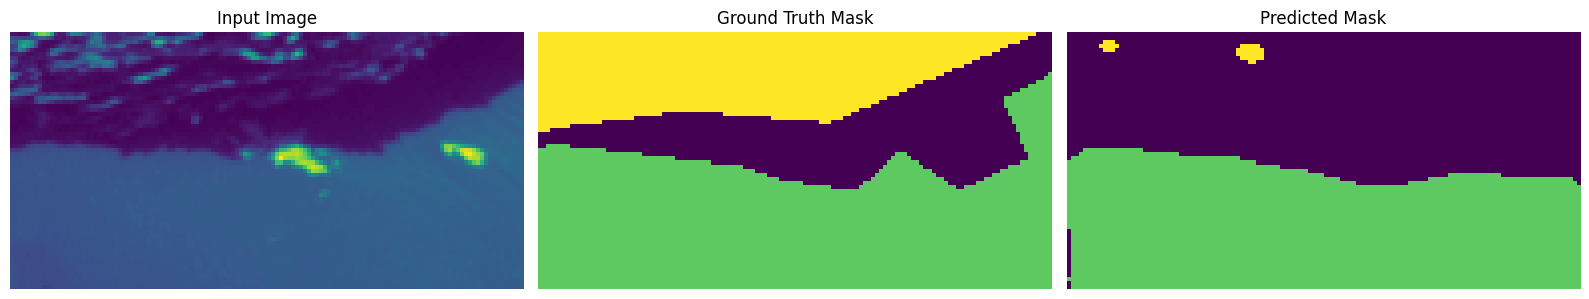

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.9459 - loss: 0.1387 - mean_iou: 0.7102 - val_accuracy: 0.7413 - val_loss: 0.9591 - val_mean_iou: 0.4564
Epoch 92/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9487 - loss: 0.1308 - mean_iou: 0.7044 - val_accuracy: 0.7473 - val_loss: 0.9552 - val_mean_iou: 0.4705
Epoch 93/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9483 - loss: 0.1312 - mean_iou: 0.7246 - val_accuracy: 0.7420 - val_loss: 1.0171 - val_mean_iou: 0.4639
Epoch 94/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9487 - loss: 0.1334 - mean_iou: 0.6970 - val_accuracy: 0.6691 - val_loss: 1.4281 - val_mean_iou: 0.3809
Epoch 95/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9472 - loss: 0.1354 - mean_iou: 0.6709 - val_accuracy: 0.7147 - val_loss: 1.1499 - val_mean_iou: 0.4471
Epoch 96/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9367 - loss: 0.1673 - mean_iou: 0.6748

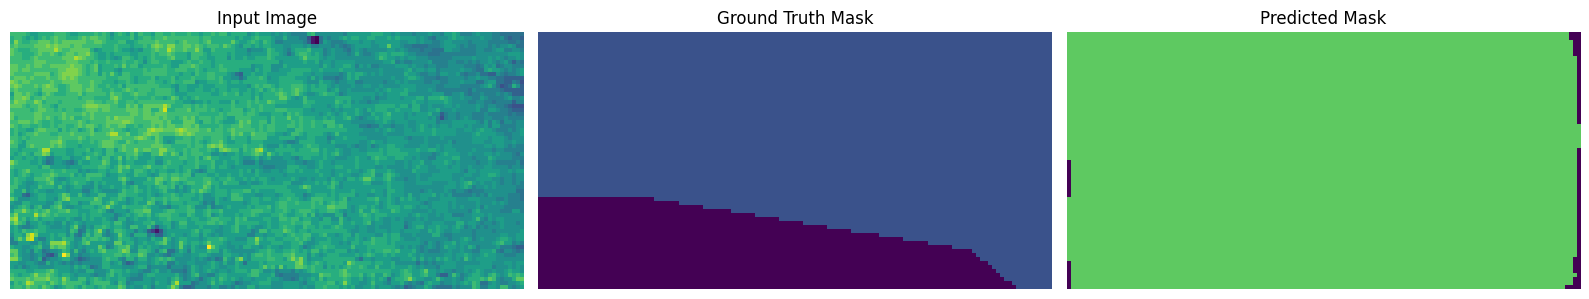

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.9366 - loss: 0.1677 - mean_iou: 0.6744 - val_accuracy: 0.6418 - val_loss: 1.4658 - val_mean_iou: 0.3550
Epoch 97/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9169 - loss: 0.2312 - mean_iou: 0.6657 - val_accuracy: 0.6461 - val_loss: 1.5598 - val_mean_iou: 0.3451
Epoch 98/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9274 - loss: 0.1952 - mean_iou: 0.6639 - val_accuracy: 0.6386 - val_loss: 1.6481 - val_mean_iou: 0.3422
Epoch 99/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9416 - loss: 0.1550 - mean_iou: 0.6915 - val_accuracy: 0.7192 - val_loss: 1.1408 - val_mean_iou: 0.4305
Epoch 100/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9490 - loss: 0.1317 - mean_iou: 0.7083 - val_accuracy: 0.7321 - val_loss: 1.1148 - val_mean_iou: 0.4393
Epoch 101/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9542 - loss: 0.1164 - mean_iou: 0.7149

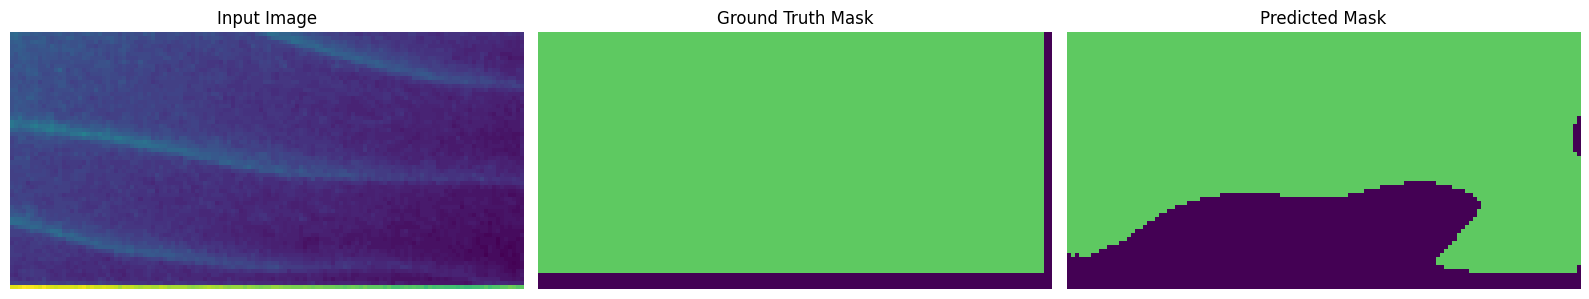

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.9542 - loss: 0.1164 - mean_iou: 0.7147 - val_accuracy: 0.7401 - val_loss: 1.0043 - val_mean_iou: 0.4574
Epoch 102/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9525 - loss: 0.1213 - mean_iou: 0.7214 - val_accuracy: 0.7157 - val_loss: 1.0951 - val_mean_iou: 0.4449
Epoch 103/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9511 - loss: 0.1263 - mean_iou: 0.7095 - val_accuracy: 0.6995 - val_loss: 1.1878 - val_mean_iou: 0.4291
Epoch 104/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9538 - loss: 0.1184 - mean_iou: 0.7194 - val_accuracy: 0.7320 - val_loss: 1.1023 - val_mean_iou: 0.4525
Epoch 105/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9485 - loss: 0.1325 - mean_iou: 0.6875 - val_accuracy: 0.7246 - val_loss: 1.2259 - val_mean_iou: 0.4360
Epoch 106/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9523 - loss: 0.1223 - mean_iou: 0.7159

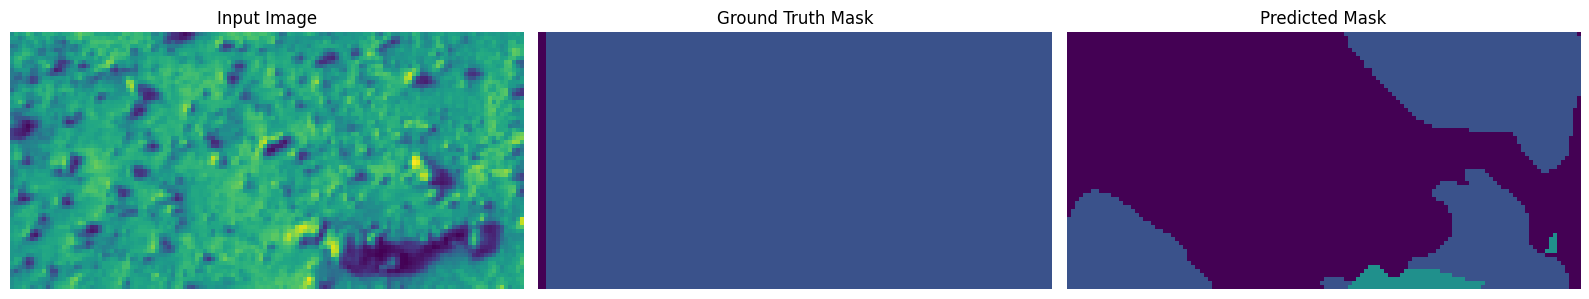

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.9523 - loss: 0.1222 - mean_iou: 0.7153 - val_accuracy: 0.7351 - val_loss: 1.0320 - val_mean_iou: 0.4531
Epoch 107/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9556 - loss: 0.1128 - mean_iou: 0.7360 - val_accuracy: 0.7372 - val_loss: 1.0461 - val_mean_iou: 0.4434
Epoch 108/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9567 - loss: 0.1105 - mean_iou: 0.7121 - val_accuracy: 0.7325 - val_loss: 1.1225 - val_mean_iou: 0.4439
Epoch 109/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9589 - loss: 0.1050 - mean_iou: 0.7278 - val_accuracy: 0.7434 - val_loss: 1.0030 - val_mean_iou: 0.4581
Epoch 110/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9565 - loss: 0.1078 - mean_iou: 0.7407 - val_accuracy: 0.7304 - val_loss: 1.1639 - val_mean_iou: 0.4342
Epoch 111/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9615 - loss: 0.0972 - mean_iou: 0.7320

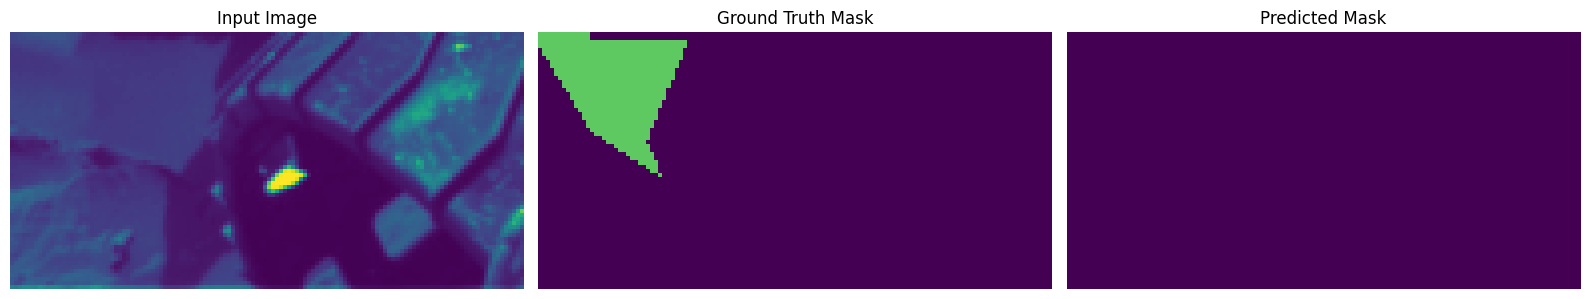

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.9615 - loss: 0.0972 - mean_iou: 0.7317 - val_accuracy: 0.7372 - val_loss: 1.1317 - val_mean_iou: 0.4494
Epoch 112/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9520 - loss: 0.1245 - mean_iou: 0.7239 - val_accuracy: 0.7028 - val_loss: 1.2546 - val_mean_iou: 0.4522
Epoch 113/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9552 - loss: 0.1146 - mean_iou: 0.7005 - val_accuracy: 0.7384 - val_loss: 1.1097 - val_mean_iou: 0.4503
Epoch 114/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9590 - loss: 0.1032 - mean_iou: 0.7116 - val_accuracy: 0.7567 - val_loss: 1.0497 - val_mean_iou: 0.4769
Epoch 115/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9621 - loss: 0.0958 - mean_iou: 0.7247 - val_accuracy: 0.7563 - val_loss: 1.0445 - val_mean_iou: 0.4783
Epoch 116/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9644 - loss: 0.0887 - mean_iou: 0.7295

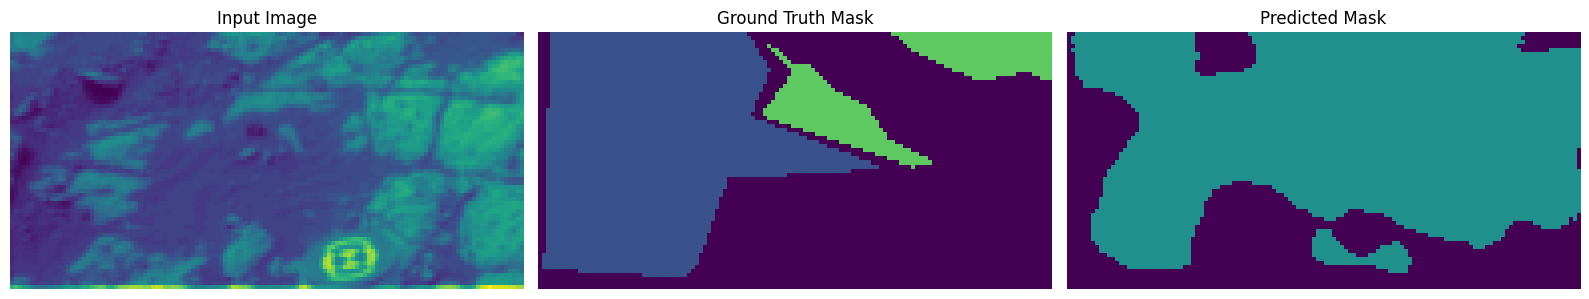

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.9644 - loss: 0.0887 - mean_iou: 0.7296 - val_accuracy: 0.7520 - val_loss: 1.0629 - val_mean_iou: 0.4771
Epoch 117/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9656 - loss: 0.0863 - mean_iou: 0.7465 - val_accuracy: 0.7466 - val_loss: 1.1137 - val_mean_iou: 0.4786
Epoch 118/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9653 - loss: 0.0871 - mean_iou: 0.7524 - val_accuracy: 0.7400 - val_loss: 1.1268 - val_mean_iou: 0.4616
Epoch 119/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9654 - loss: 0.0874 - mean_iou: 0.7422 - val_accuracy: 0.7455 - val_loss: 1.1668 - val_mean_iou: 0.4591
Epoch 120/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9558 - loss: 0.1147 - mean_iou: 0.7238 - val_accuracy: 0.7320 - val_loss: 1.1745 - val_mean_iou: 0.4544
Epoch 121/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9547 - loss: 0.1185 - mean_iou: 0.7233

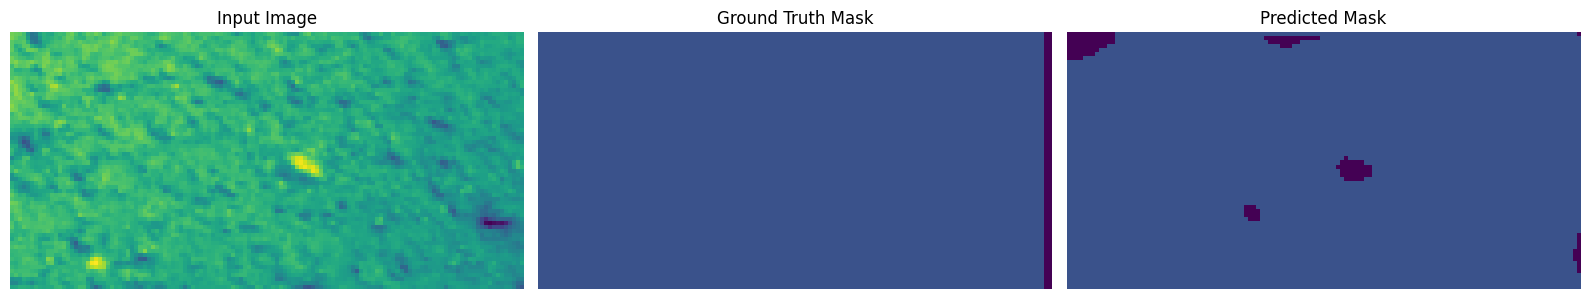

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.9547 - loss: 0.1187 - mean_iou: 0.7230 - val_accuracy: 0.7082 - val_loss: 1.2688 - val_mean_iou: 0.4252
Epoch 122/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9480 - loss: 0.1351 - mean_iou: 0.7092 - val_accuracy: 0.5189 - val_loss: 2.6615 - val_mean_iou: 0.2317
Epoch 123/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9457 - loss: 0.1483 - mean_iou: 0.7112 - val_accuracy: 0.6923 - val_loss: 1.4040 - val_mean_iou: 0.4198
Epoch 124/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9491 - loss: 0.1324 - mean_iou: 0.7115 - val_accuracy: 0.7278 - val_loss: 1.1834 - val_mean_iou: 0.4665
Epoch 125/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9488 - loss: 0.1344 - mean_iou: 0.7018 - val_accuracy: 0.7142 - val_loss: 1.3289 - val_mean_iou: 0.4353
Epoch 126/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9529 - loss: 0.1224 - mean_iou: 0.7206

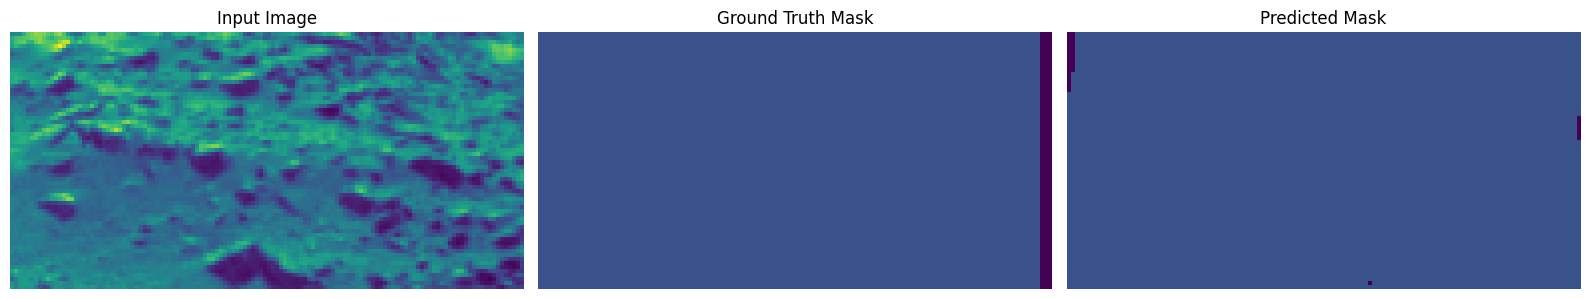

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.9529 - loss: 0.1225 - mean_iou: 0.7202 - val_accuracy: 0.7245 - val_loss: 1.2335 - val_mean_iou: 0.4713
Epoch 127/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9551 - loss: 0.1150 - mean_iou: 0.7104 - val_accuracy: 0.7430 - val_loss: 1.1905 - val_mean_iou: 0.4601
Epoch 128/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9597 - loss: 0.1018 - mean_iou: 0.7281 - val_accuracy: 0.7355 - val_loss: 1.1641 - val_mean_iou: 0.4536
Epoch 129/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9615 - loss: 0.0982 - mean_iou: 0.6990 - val_accuracy: 0.7451 - val_loss: 1.1891 - val_mean_iou: 0.4635
Epoch 130/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9643 - loss: 0.0903 - mean_iou: 0.7400 - val_accuracy: 0.7528 - val_loss: 1.1079 - val_mean_iou: 0.4768
Epoch 131/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9666 - loss: 0.0840 - mean_iou: 0.7485

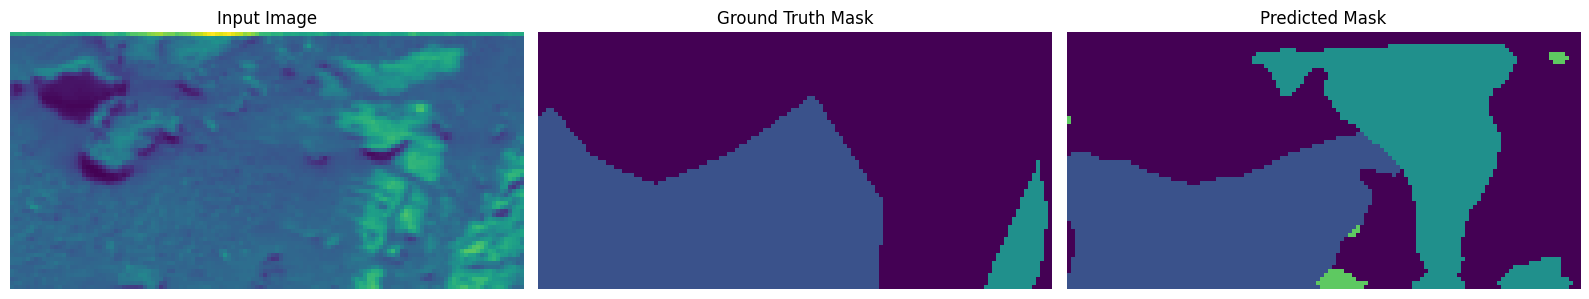

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.9666 - loss: 0.0840 - mean_iou: 0.7482 - val_accuracy: 0.7470 - val_loss: 1.1488 - val_mean_iou: 0.4726
Epoch 132/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9681 - loss: 0.0808 - mean_iou: 0.7593 - val_accuracy: 0.7381 - val_loss: 1.1722 - val_mean_iou: 0.4496
Epoch 133/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9652 - loss: 0.0875 - mean_iou: 0.7432 - val_accuracy: 0.7427 - val_loss: 1.1908 - val_mean_iou: 0.4562
Epoch 134/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9684 - loss: 0.0790 - mean_iou: 0.7487 - val_accuracy: 0.7400 - val_loss: 1.2106 - val_mean_iou: 0.4689
Epoch 135/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9692 - loss: 0.0762 - mean_iou: 0.7429 - val_accuracy: 0.7455 - val_loss: 1.1692 - val_mean_iou: 0.4726
Epoch 136/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9699 - loss: 0.0754 - mean_iou: 0.7442

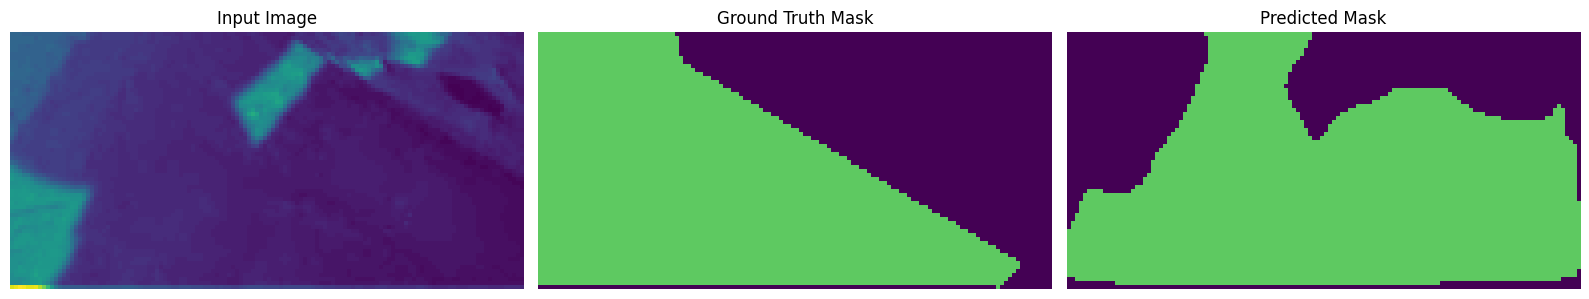

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.9700 - loss: 0.0753 - mean_iou: 0.7444 - val_accuracy: 0.7373 - val_loss: 1.1791 - val_mean_iou: 0.4719
Epoch 137/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9713 - loss: 0.0712 - mean_iou: 0.7581 - val_accuracy: 0.7503 - val_loss: 1.1807 - val_mean_iou: 0.4721
Epoch 138/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9720 - loss: 0.0696 - mean_iou: 0.7532 - val_accuracy: 0.7518 - val_loss: 1.1878 - val_mean_iou: 0.4737
Epoch 139/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9734 - loss: 0.0661 - mean_iou: 0.7436 - val_accuracy: 0.7439 - val_loss: 1.2157 - val_mean_iou: 0.4704
Epoch 140/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9435 - loss: 0.1576 - mean_iou: 0.7083 - val_accuracy: 0.6827 - val_loss: 1.7132 - val_mean_iou: 0.4094
Epoch 141/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9423 - loss: 0.1602 - mean_iou: 0.7014

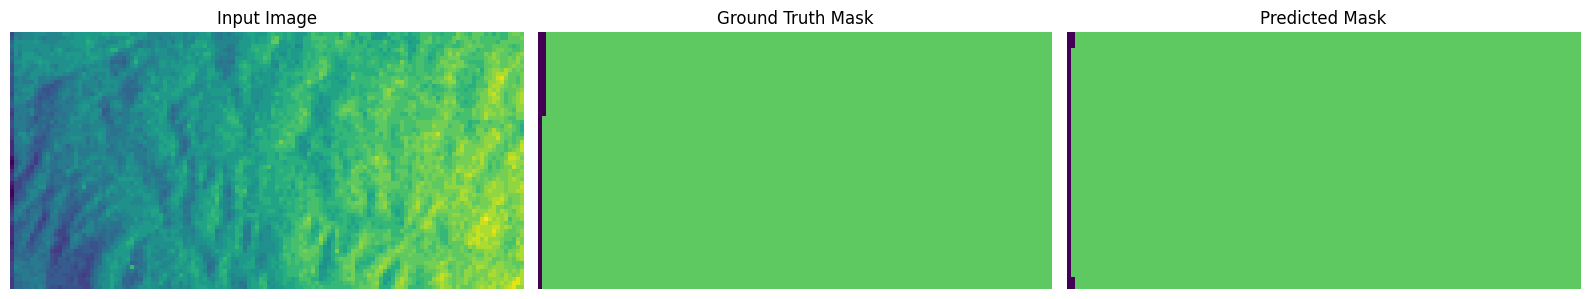

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.9421 - loss: 0.1609 - mean_iou: 0.7004 - val_accuracy: 0.4396 - val_loss: 6.2692 - val_mean_iou: 0.1583
Epoch 142/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9105 - loss: 0.2486 - mean_iou: 0.6720 - val_accuracy: 0.5886 - val_loss: 1.8998 - val_mean_iou: 0.3217
Epoch 143/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9274 - loss: 0.2009 - mean_iou: 0.6847 - val_accuracy: 0.5252 - val_loss: 2.9731 - val_mean_iou: 0.2368
Epoch 144/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9300 - loss: 0.1973 - mean_iou: 0.6837 - val_accuracy: 0.6072 - val_loss: 1.8220 - val_mean_iou: 0.3437
Epoch 145/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9485 - loss: 0.1331 - mean_iou: 0.7310 - val_accuracy: 0.6701 - val_loss: 1.6962 - val_mean_iou: 0.3859
Epoch 146/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9556 - loss: 0.1152 - mean_iou: 0.7166

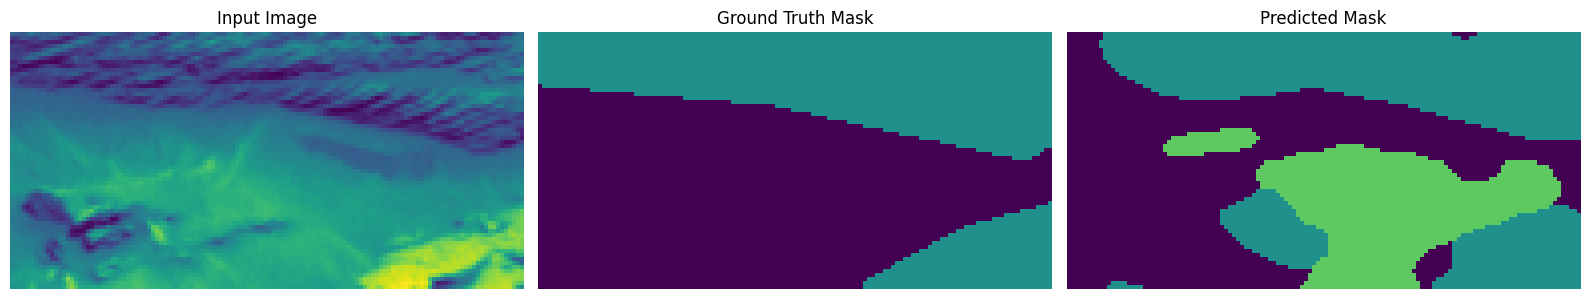

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.9557 - loss: 0.1152 - mean_iou: 0.7166 - val_accuracy: 0.7164 - val_loss: 1.3964 - val_mean_iou: 0.4285
Epoch 147/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9599 - loss: 0.1015 - mean_iou: 0.7345 - val_accuracy: 0.6784 - val_loss: 1.5891 - val_mean_iou: 0.3773
Epoch 148/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9625 - loss: 0.0951 - mean_iou: 0.7271 - val_accuracy: 0.6908 - val_loss: 1.5392 - val_mean_iou: 0.3956
Epoch 149/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9672 - loss: 0.0839 - mean_iou: 0.7220 - val_accuracy: 0.6867 - val_loss: 1.5346 - val_mean_iou: 0.3949
Epoch 150/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9673 - loss: 0.0829 - mean_iou: 0.7473 - val_accuracy: 0.7394 - val_loss: 1.1967 - val_mean_iou: 0.4588
Epoch 151/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9699 - loss: 0.0756 - mean_iou: 0.7588

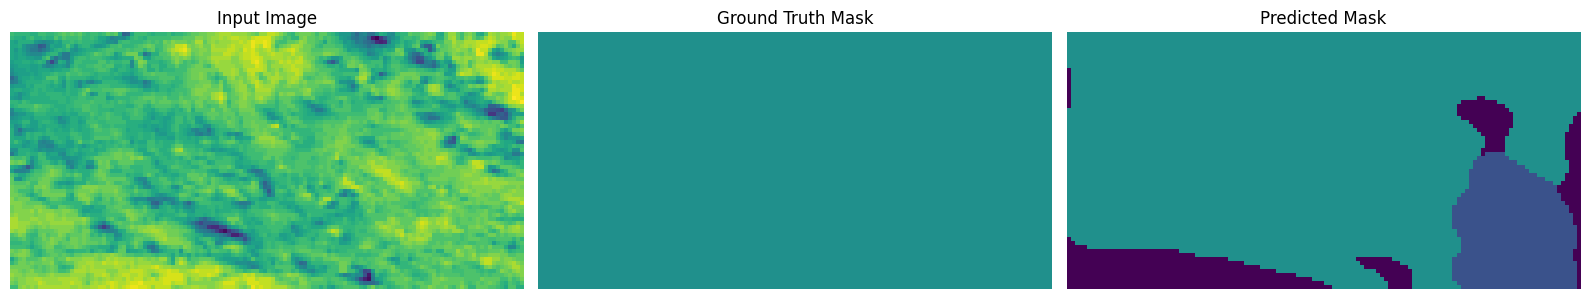

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.9699 - loss: 0.0756 - mean_iou: 0.7585 - val_accuracy: 0.7487 - val_loss: 1.1351 - val_mean_iou: 0.4695
Epoch 152/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9715 - loss: 0.0705 - mean_iou: 0.7570 - val_accuracy: 0.7319 - val_loss: 1.2370 - val_mean_iou: 0.4474
Epoch 153/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9725 - loss: 0.0689 - mean_iou: 0.7357 - val_accuracy: 0.7471 - val_loss: 1.1640 - val_mean_iou: 0.4706
Epoch 154/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9731 - loss: 0.0668 - mean_iou: 0.7509 - val_accuracy: 0.7479 - val_loss: 1.1594 - val_mean_iou: 0.4763
Final validation Mean Intersection Over Union: 47.88%


In [ ]:
history = model.fit(
    train_dataset,
    epochs=epoch,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')


# Definisci il percorso di salvataggio nella directory di lavoro
model.save("/kaggle/working/UNet_SecondoTentativo.keras")


# Delete the model to free up resources
del model

# Save model

In [ ]:
model_filename = "UNet_SecondoTentativo.keras"

X_test = np.load("/kaggle/input/datasetlomi/test_set.npz")
model = tfk.models.load_model("/kaggle/working/UNet_SecondoTentativo.keras")

preds = model.predict(X_test["images"]/255)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

(10022, 64, 128)
Test set shape after adding channel: (10022, 64, 128, 1)
314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step
Predictions shape: (10022, 64, 128, 5)
Predictions after argmax shape: (10022, 64, 128)
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


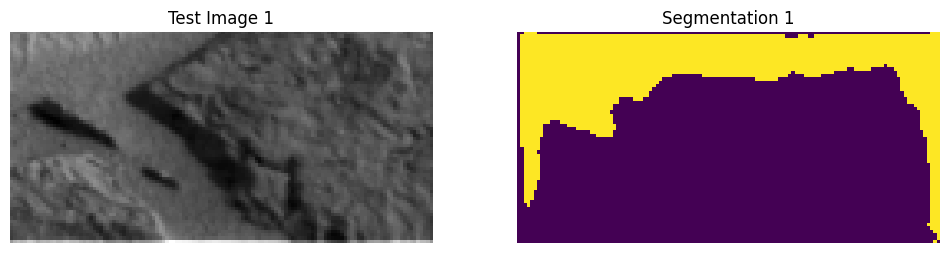

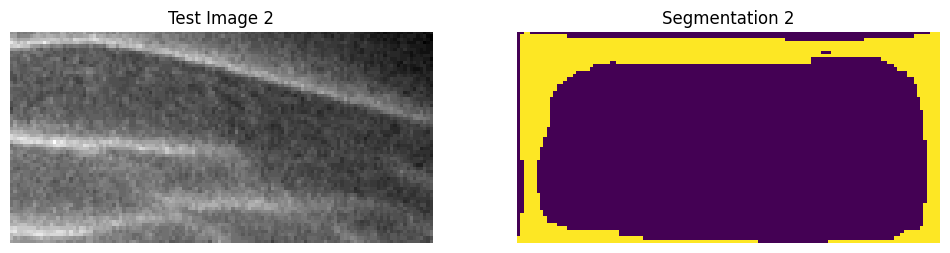

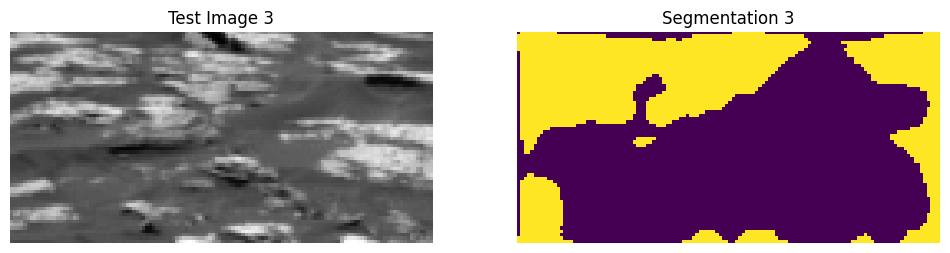

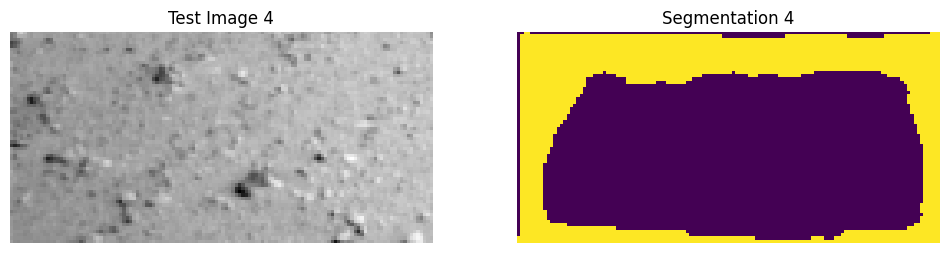

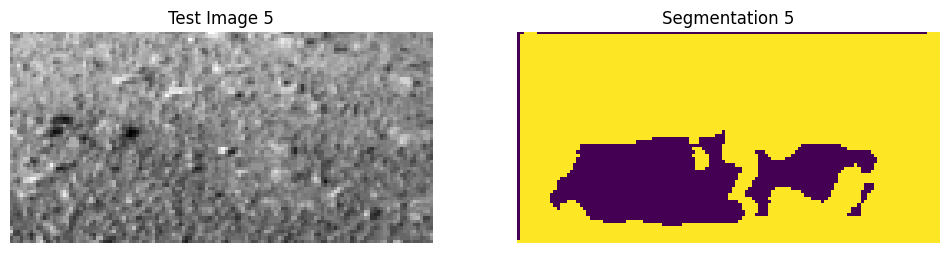

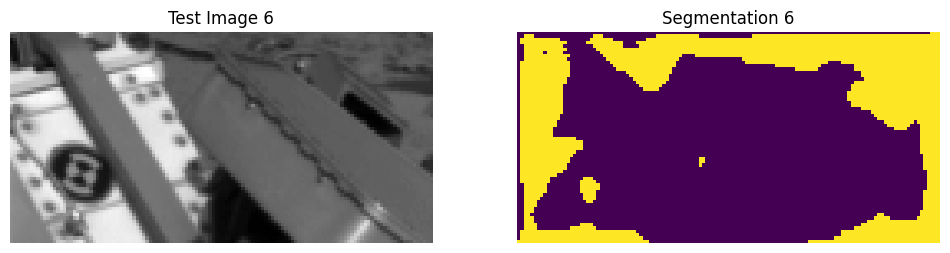

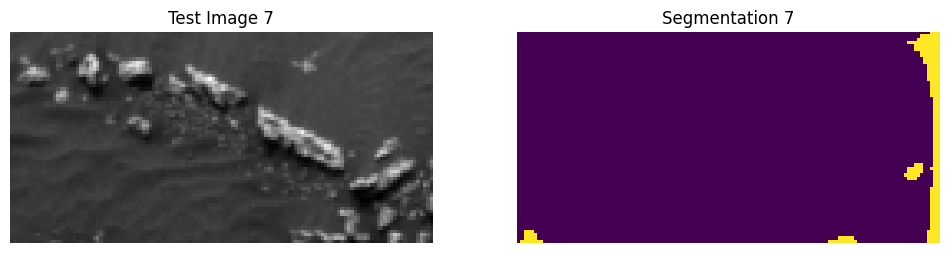

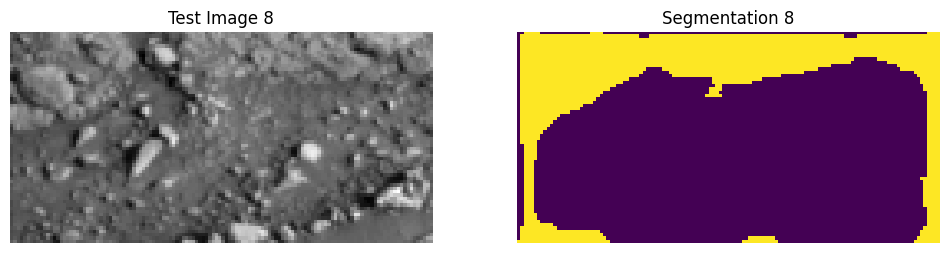

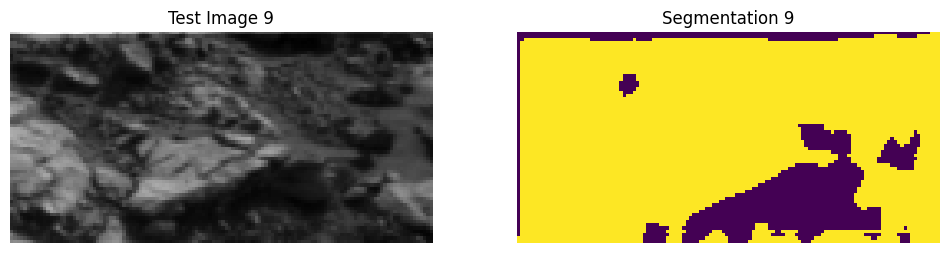

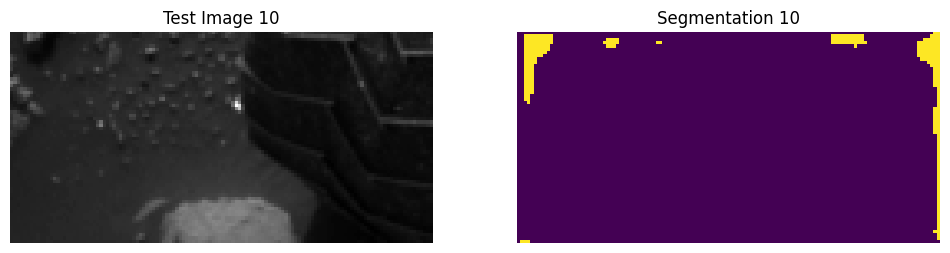

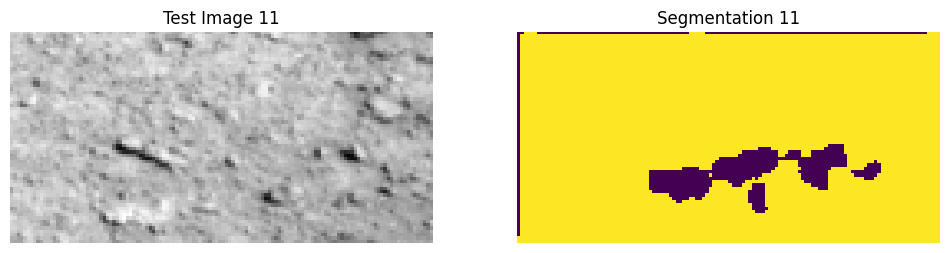

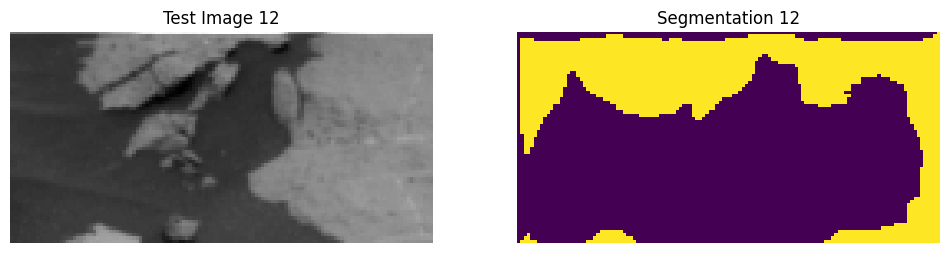

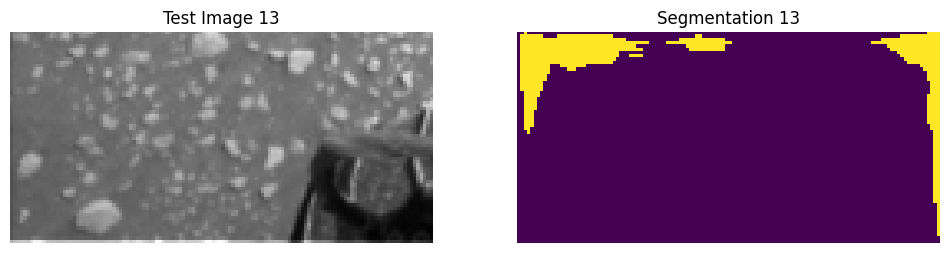

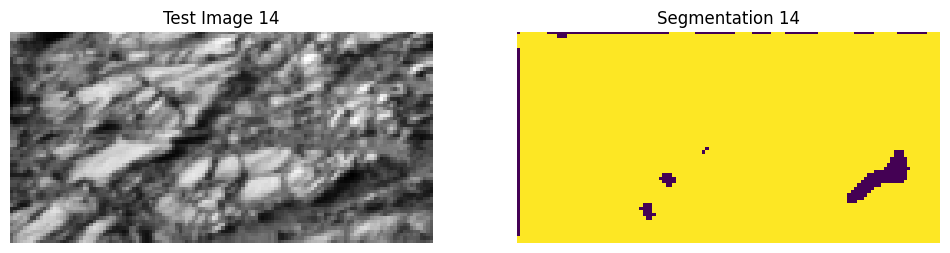

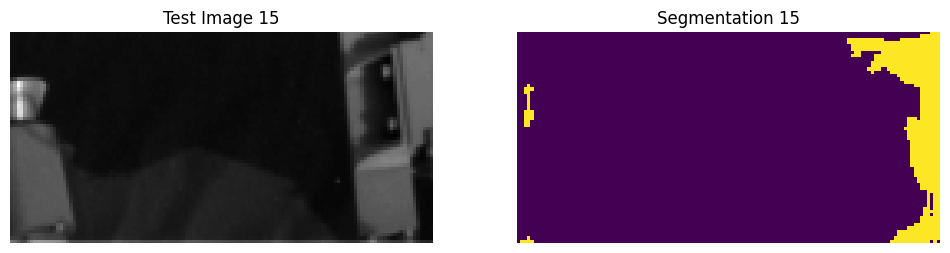

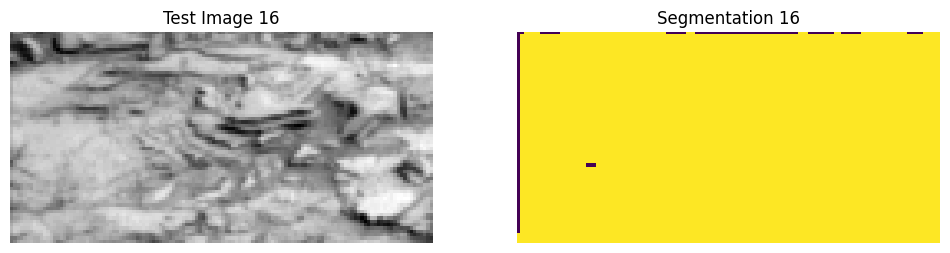

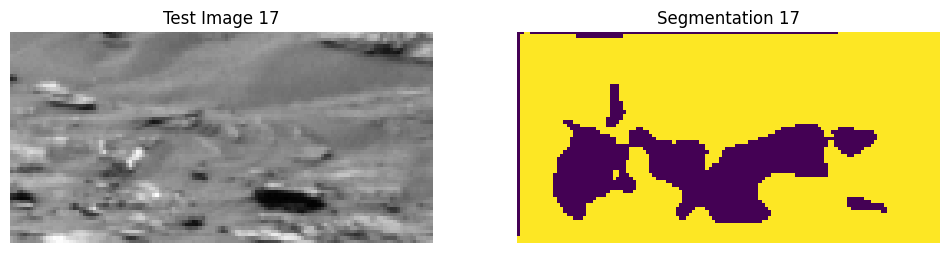

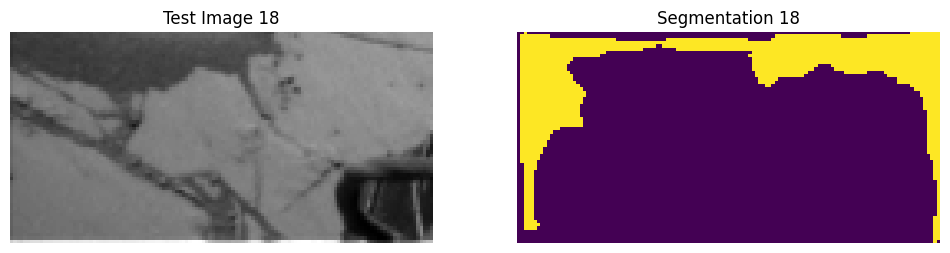

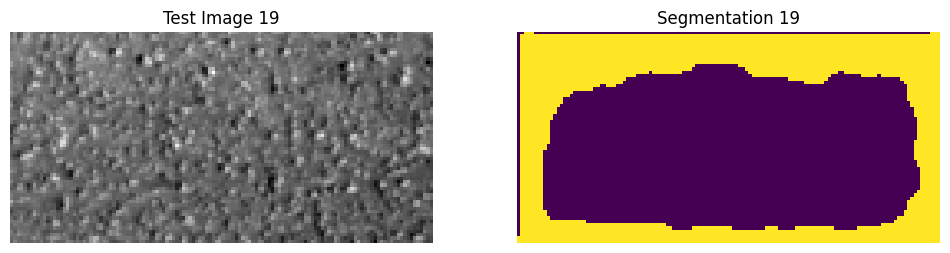

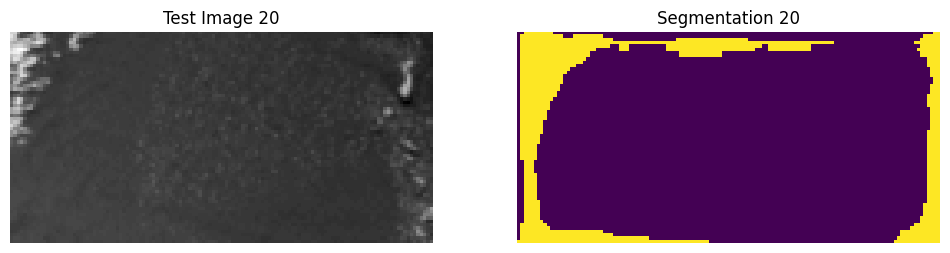

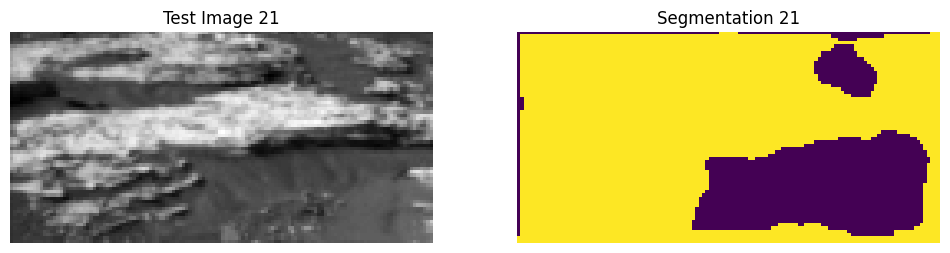

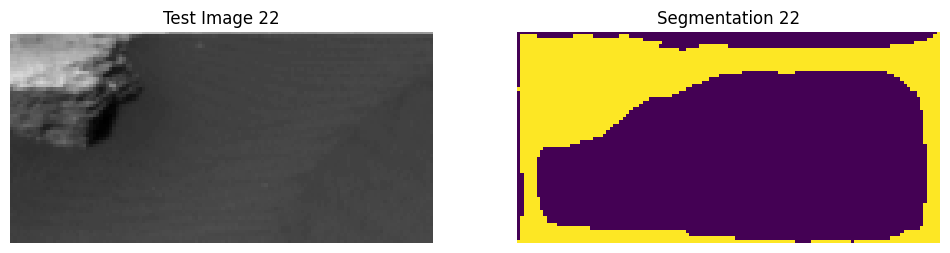

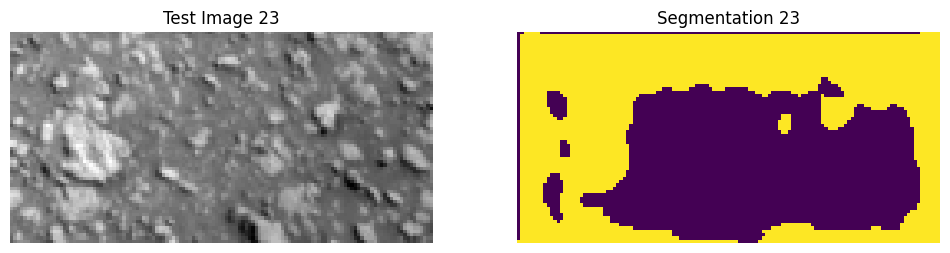

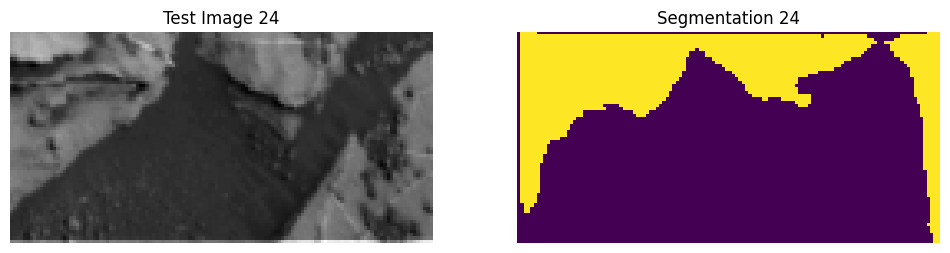

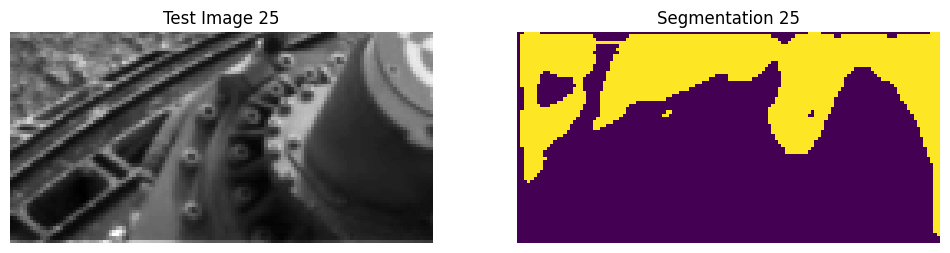

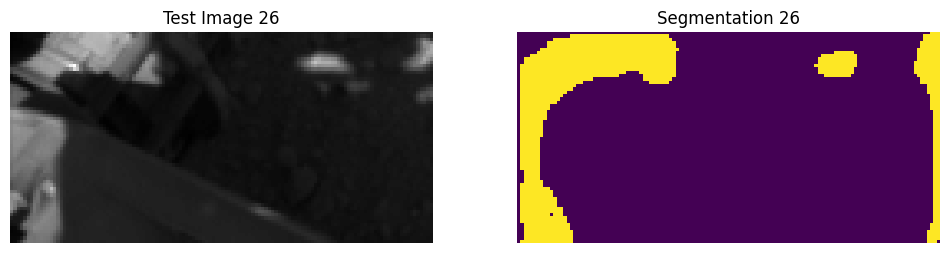

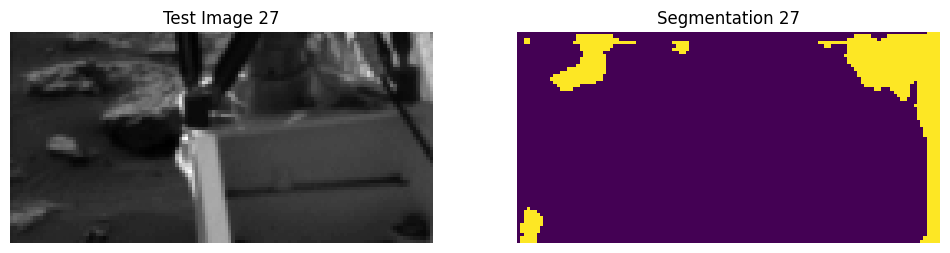

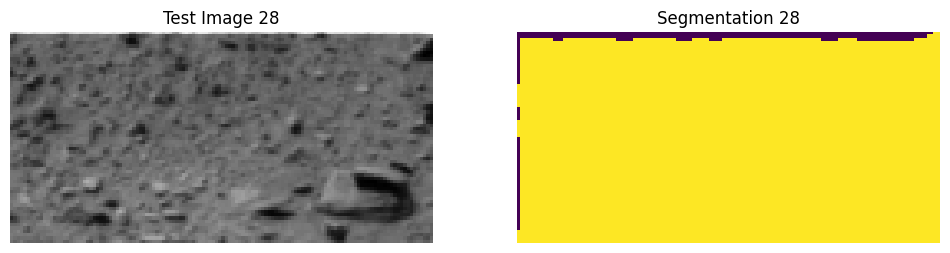

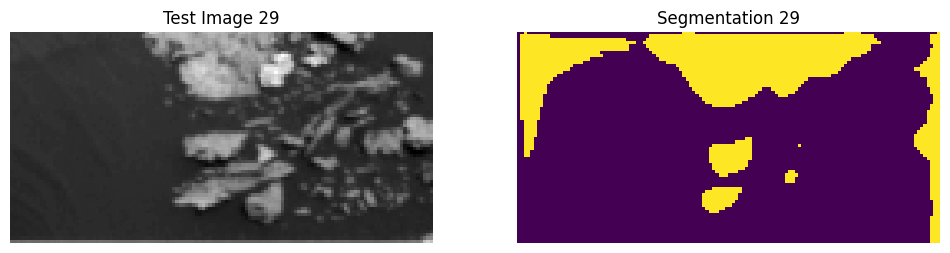

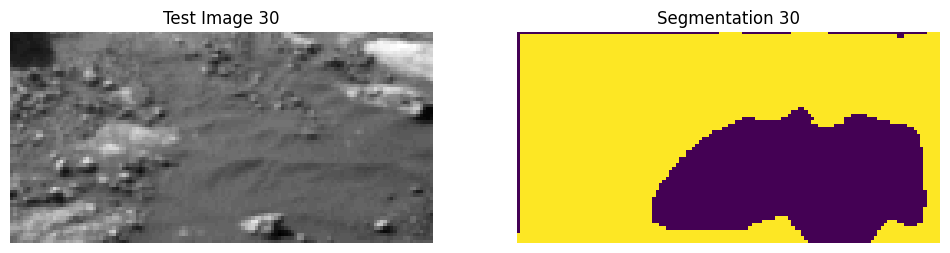

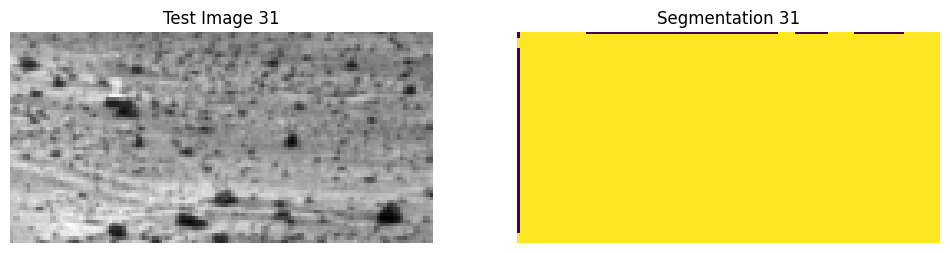

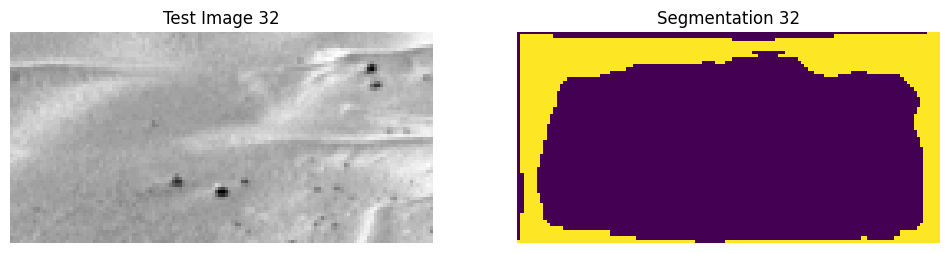

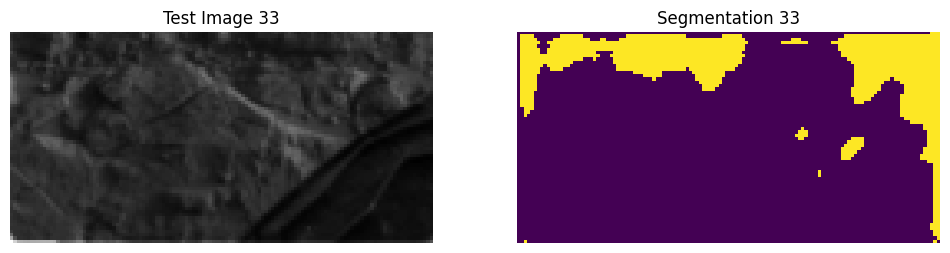

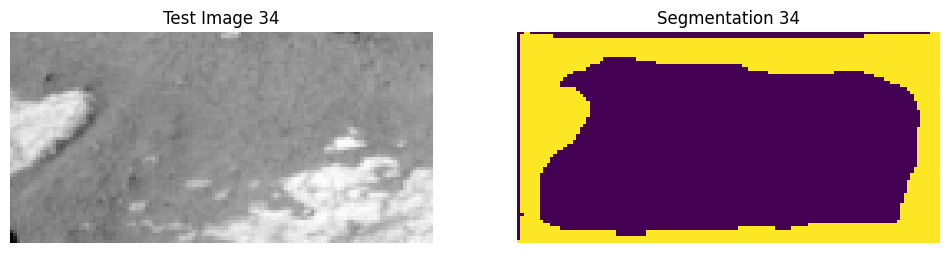

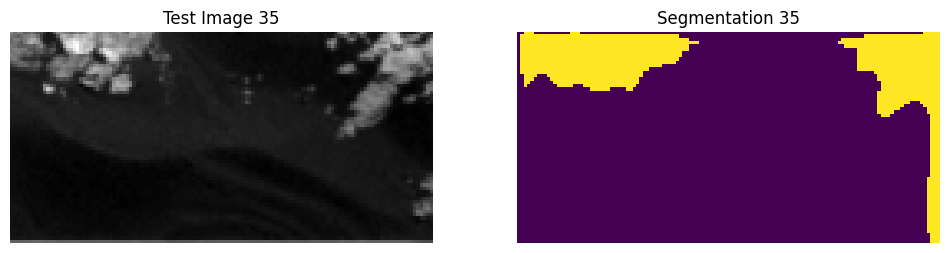

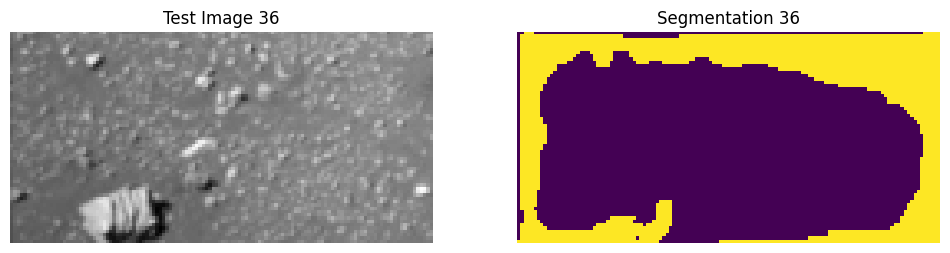

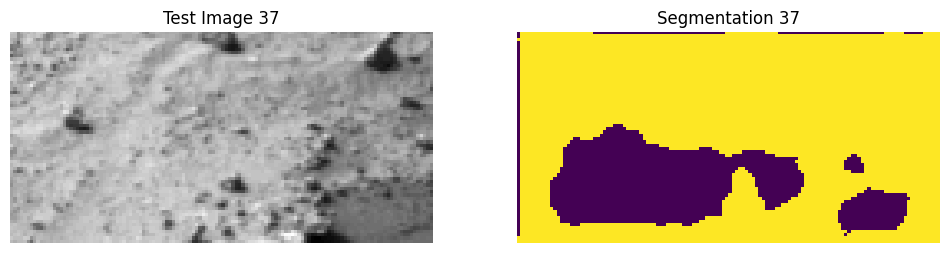

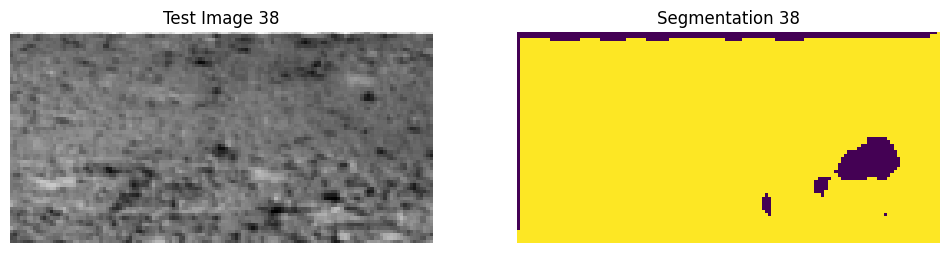

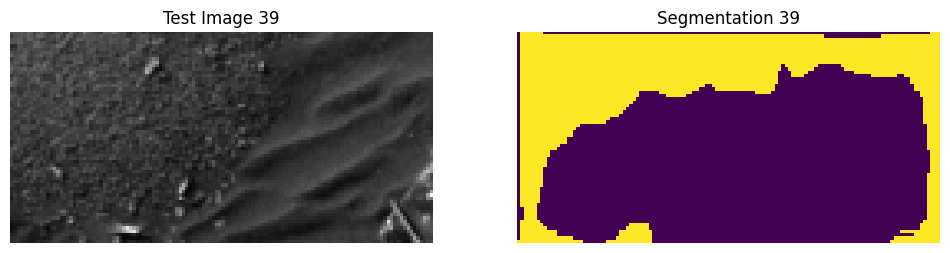

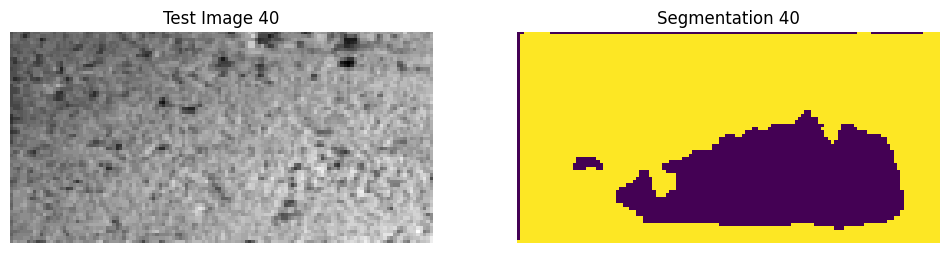

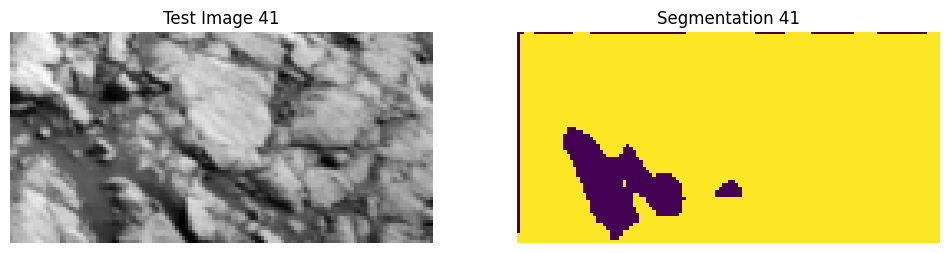

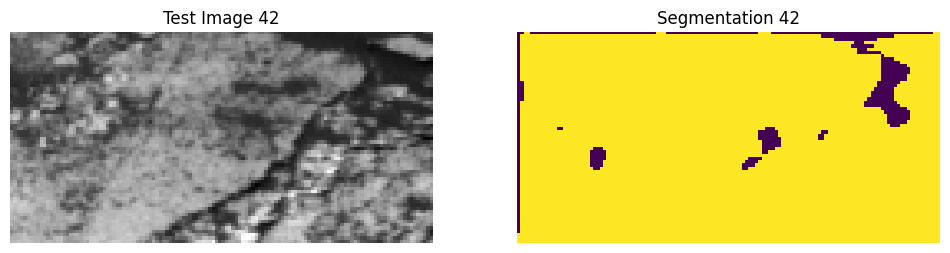

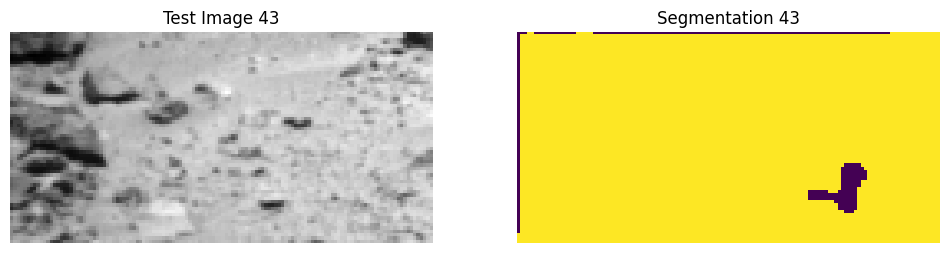

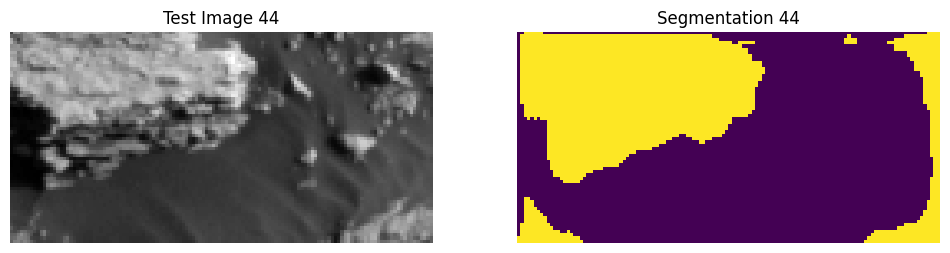

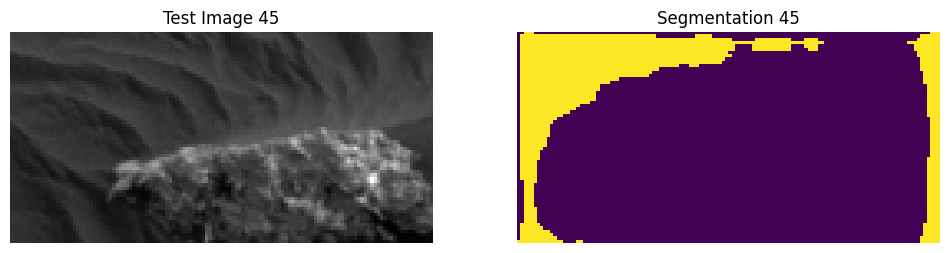

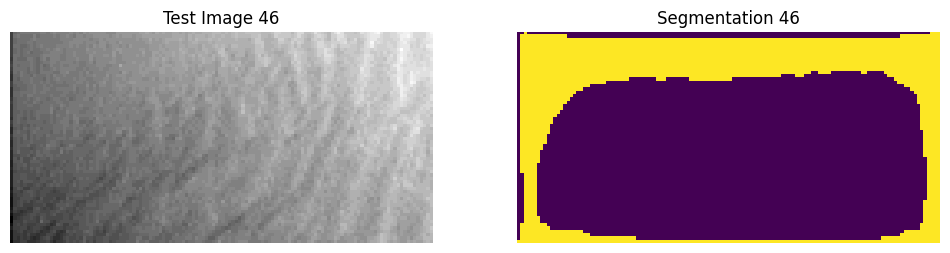

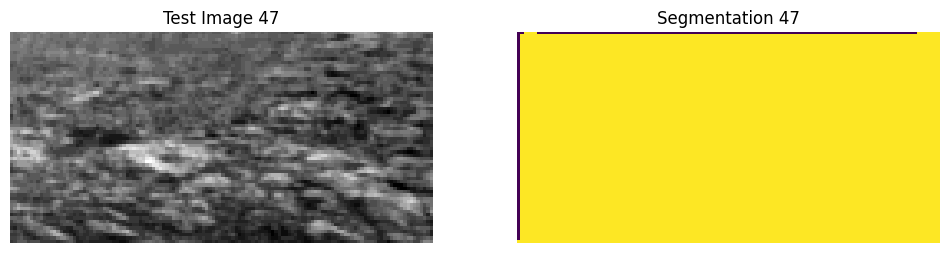

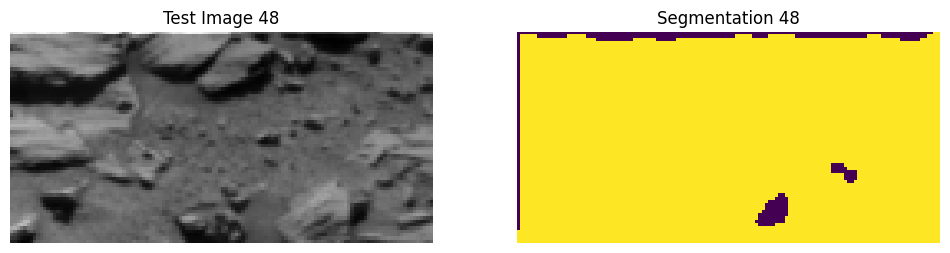

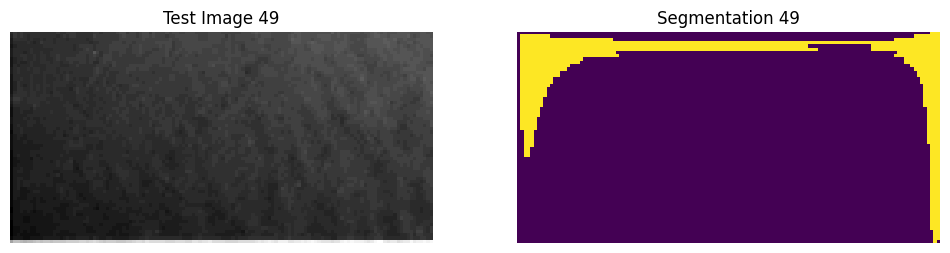

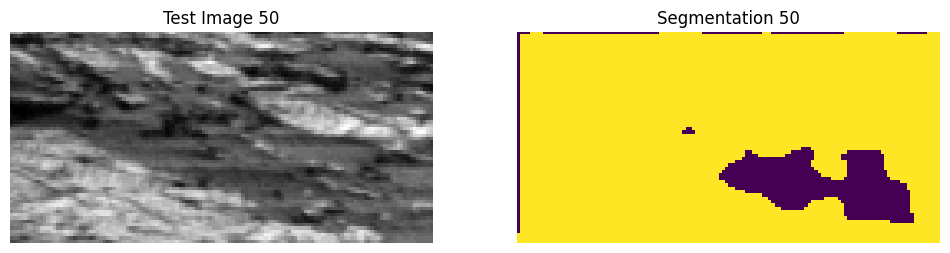

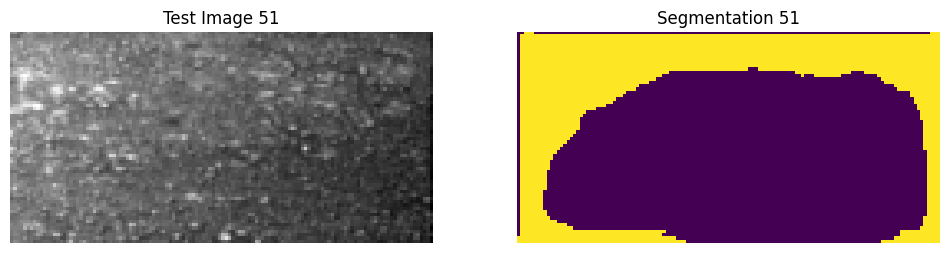

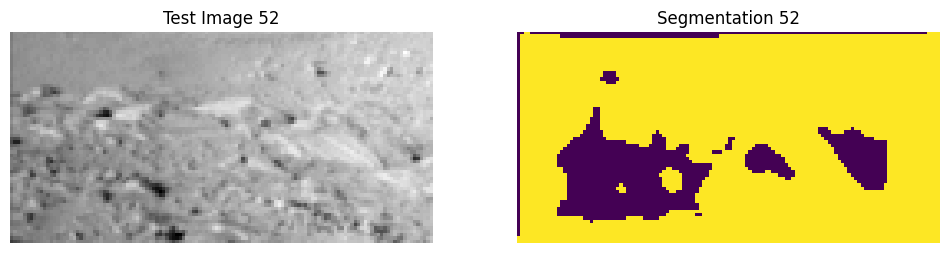

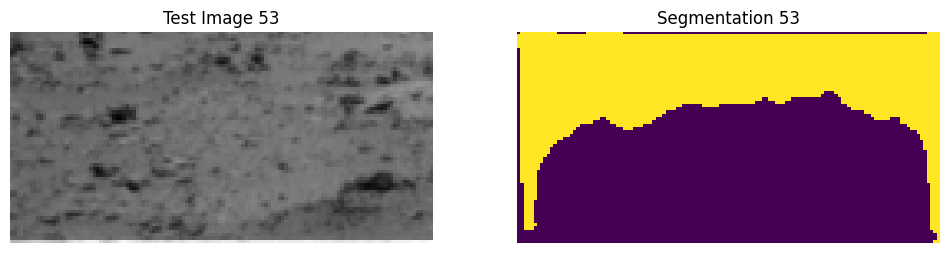

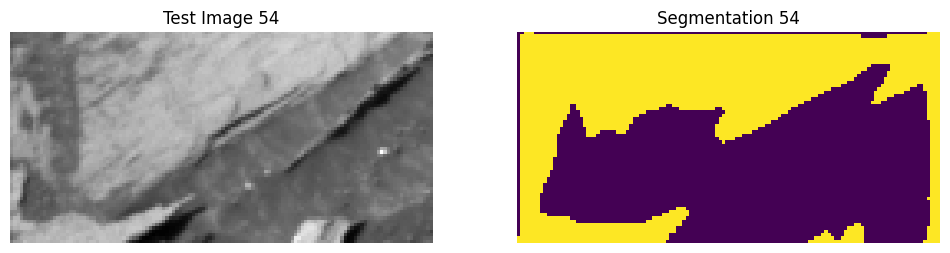

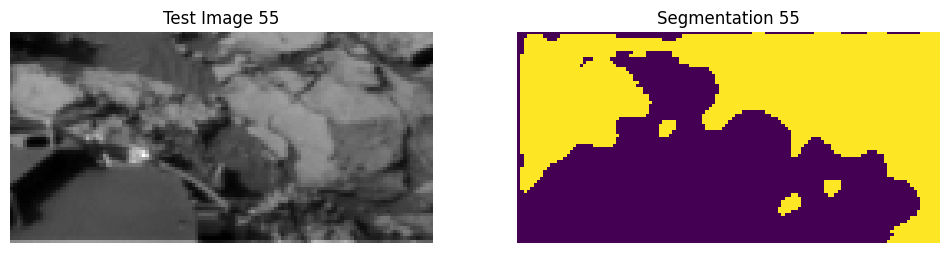

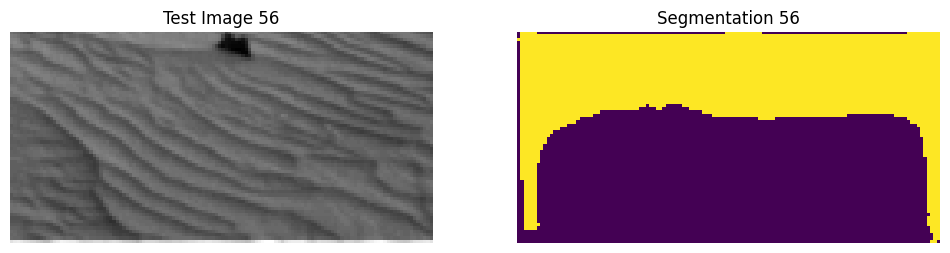

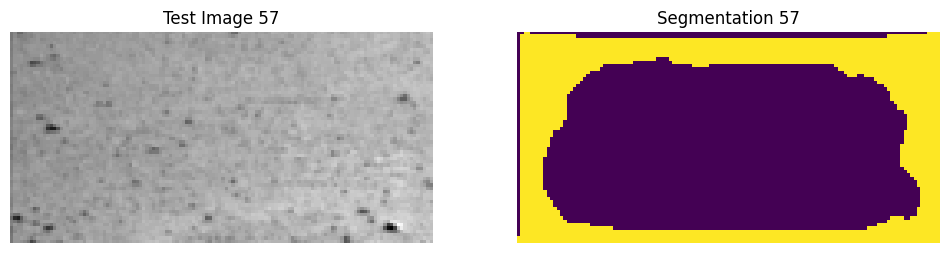

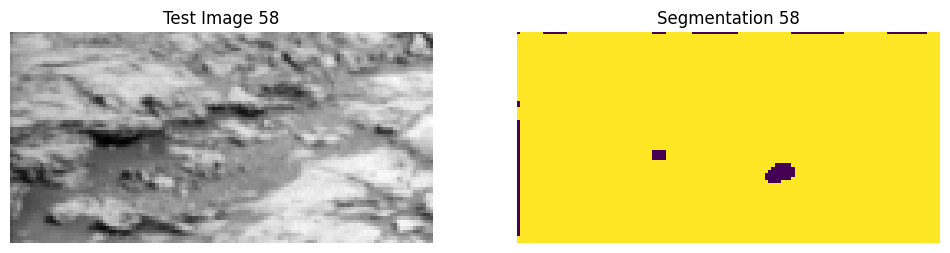

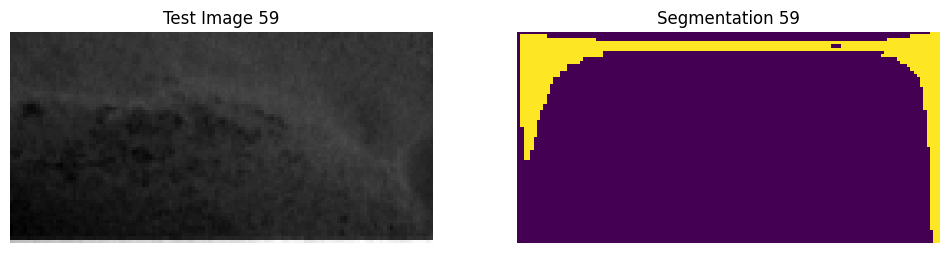

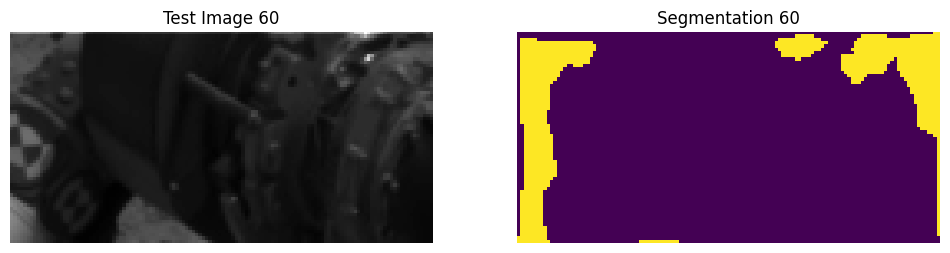

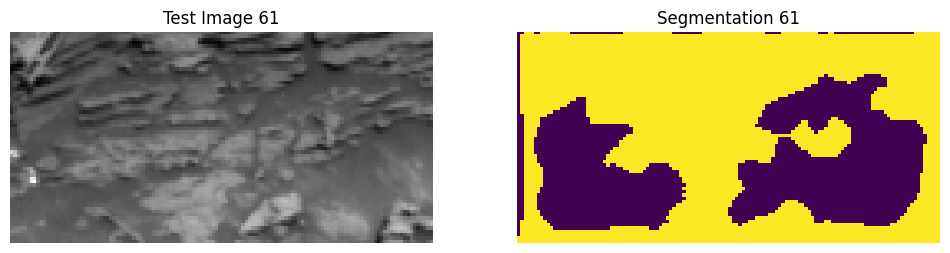

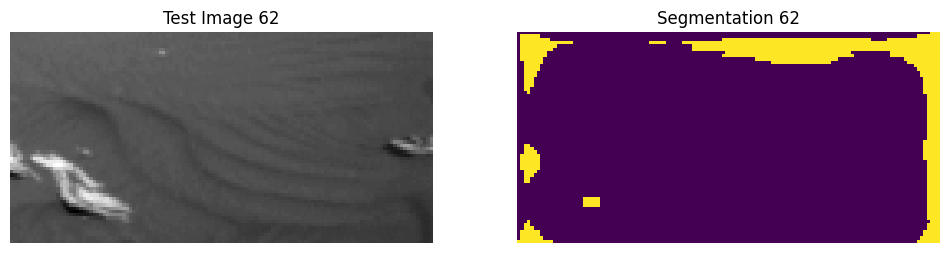

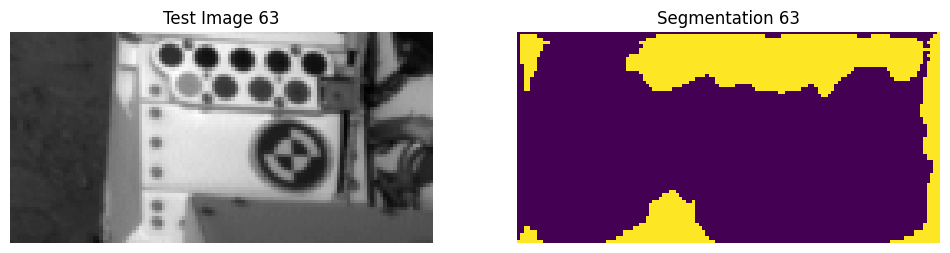

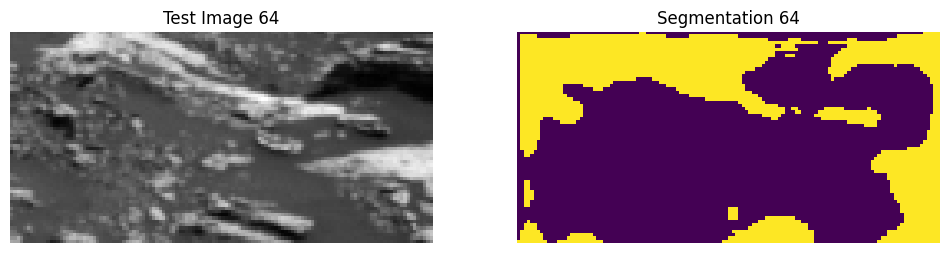

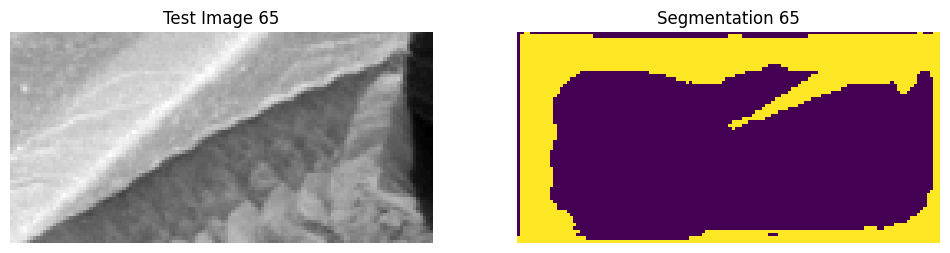

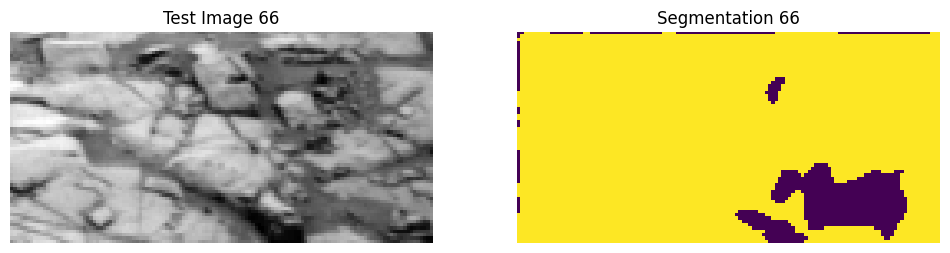

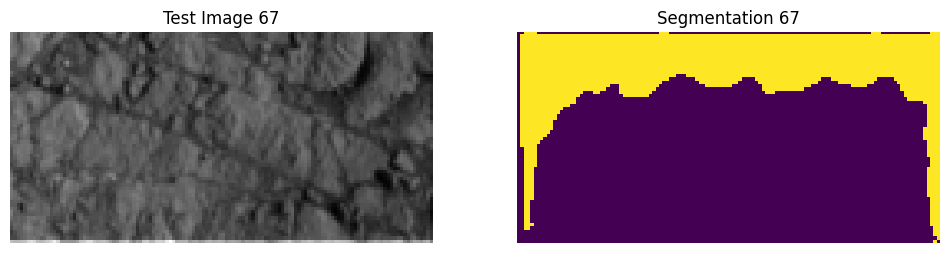

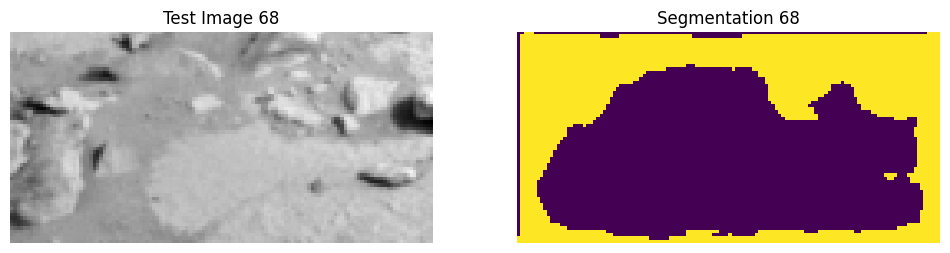

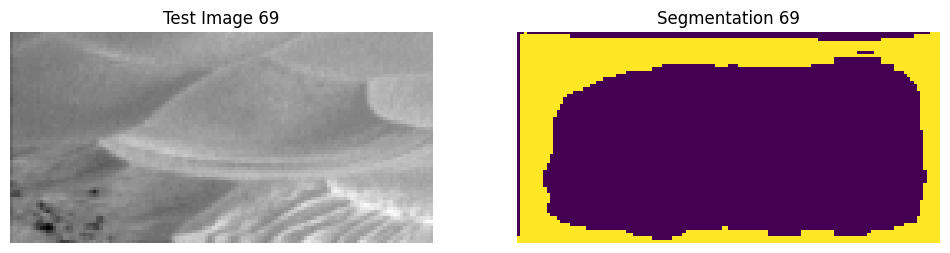

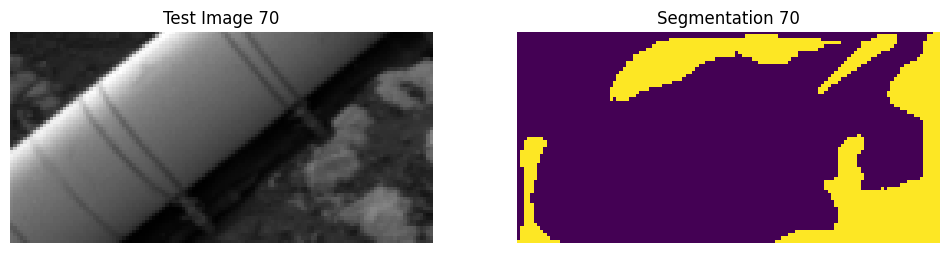

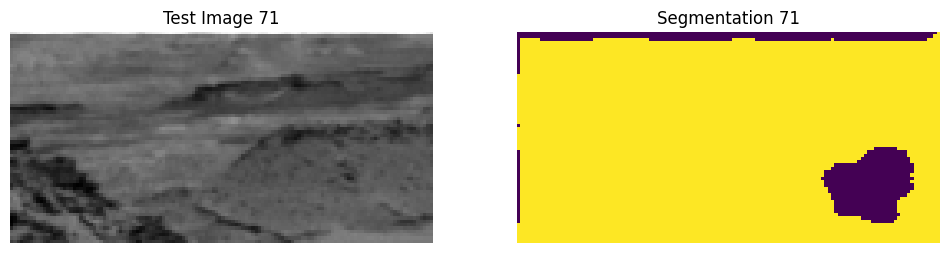

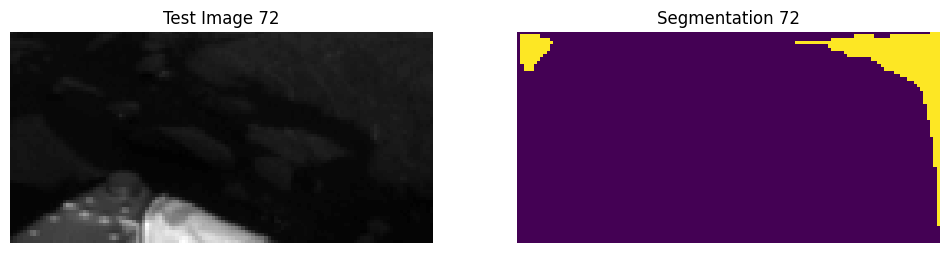

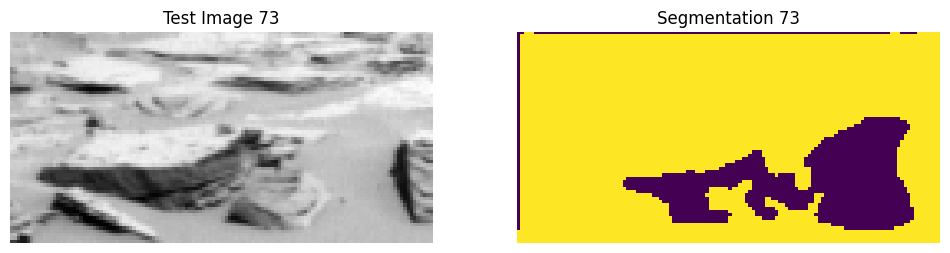

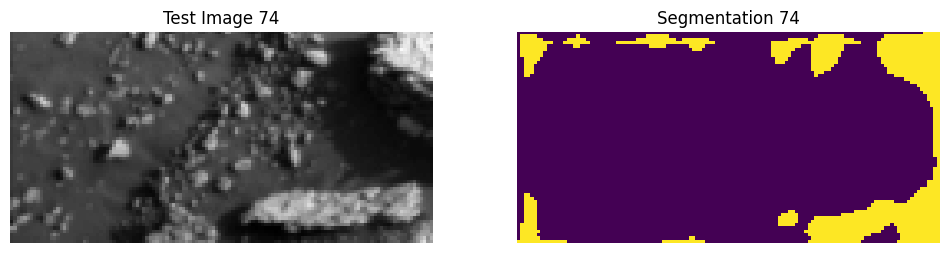

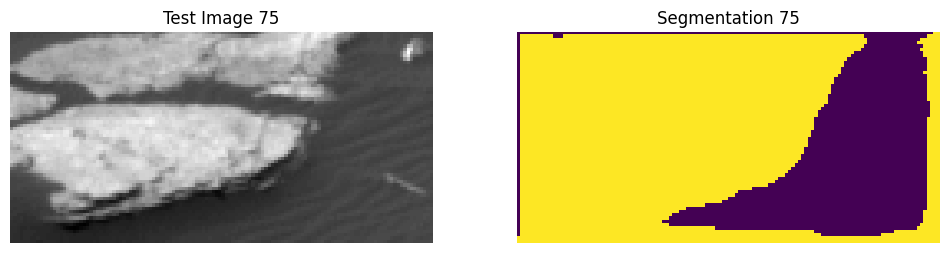

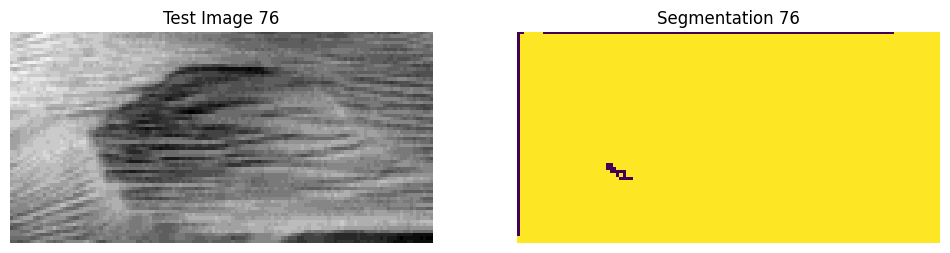

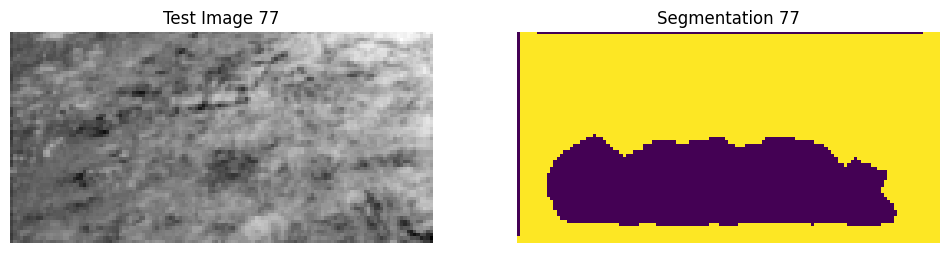

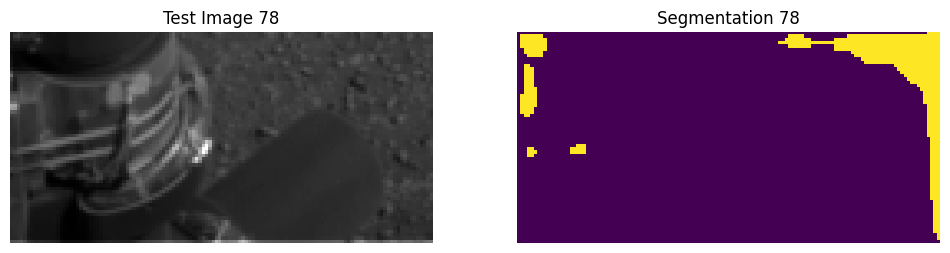

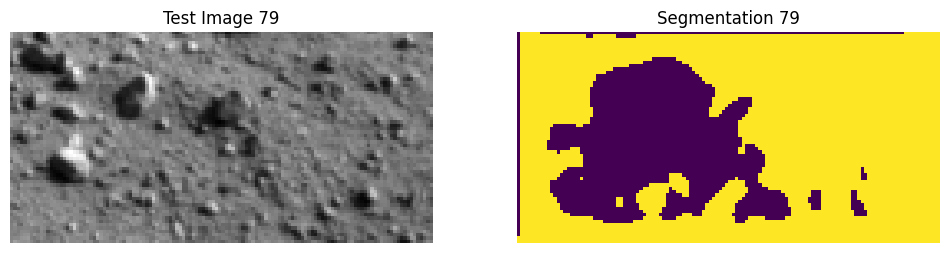

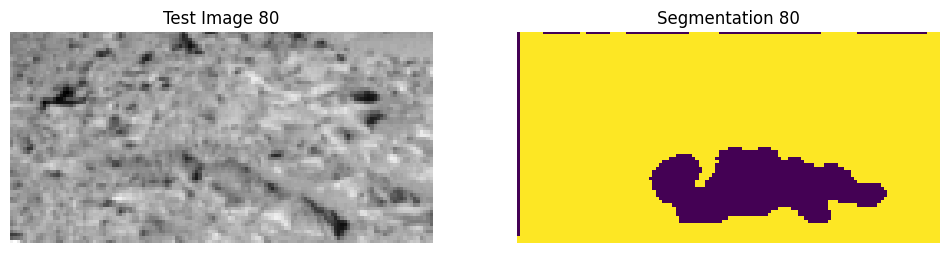

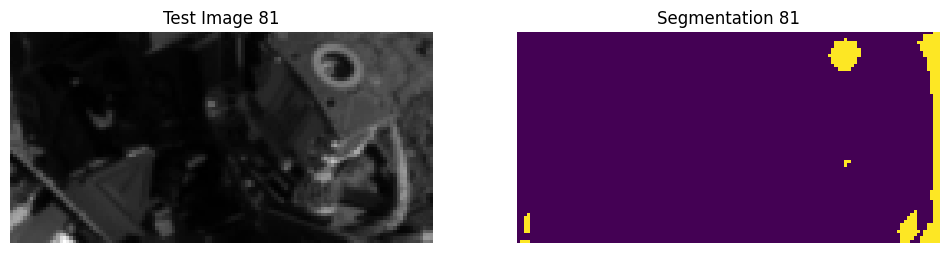

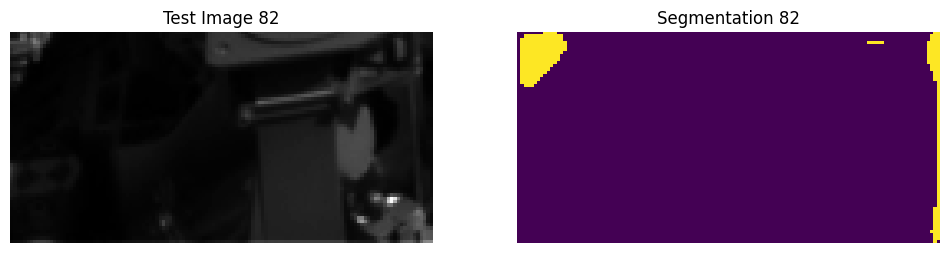

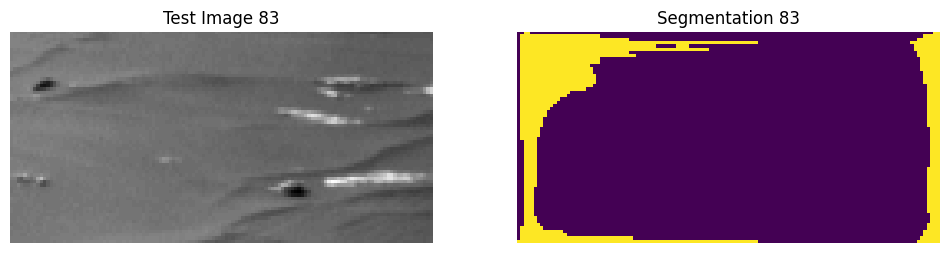

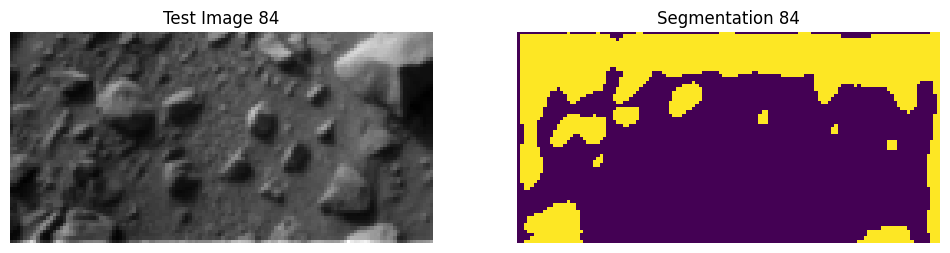

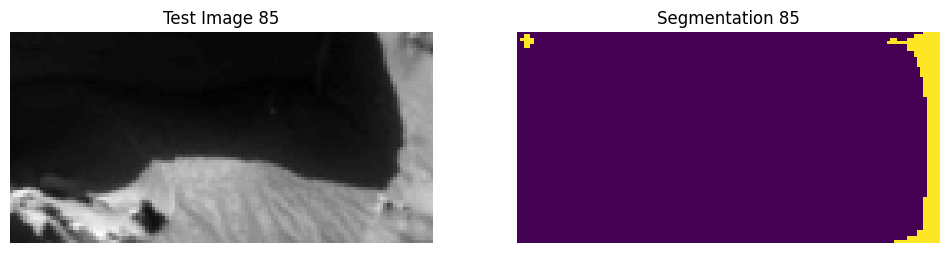

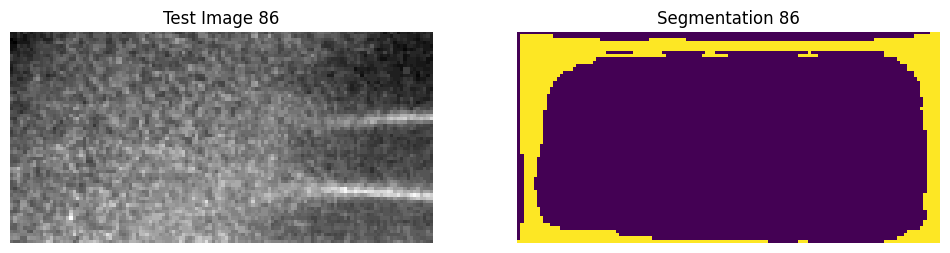

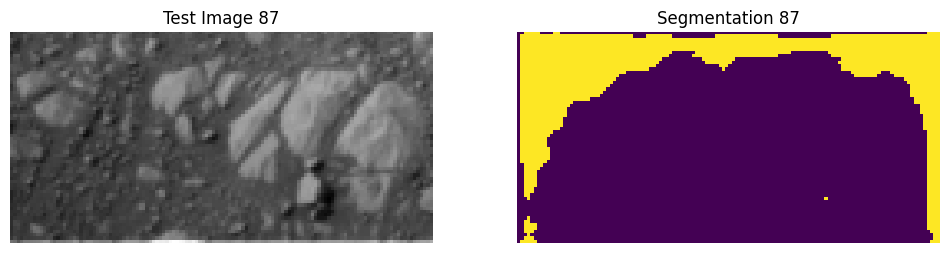

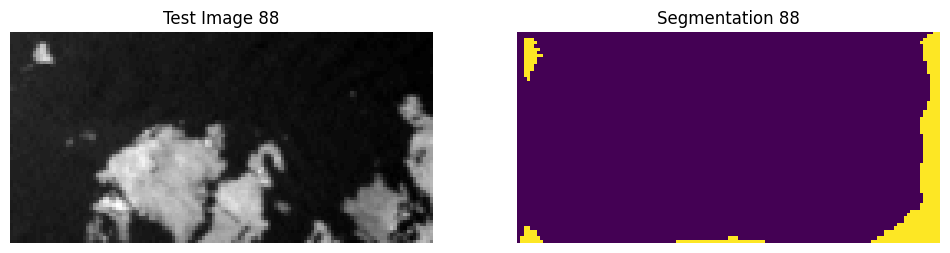

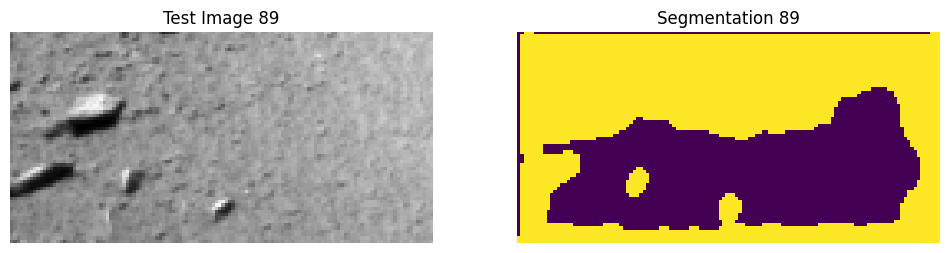

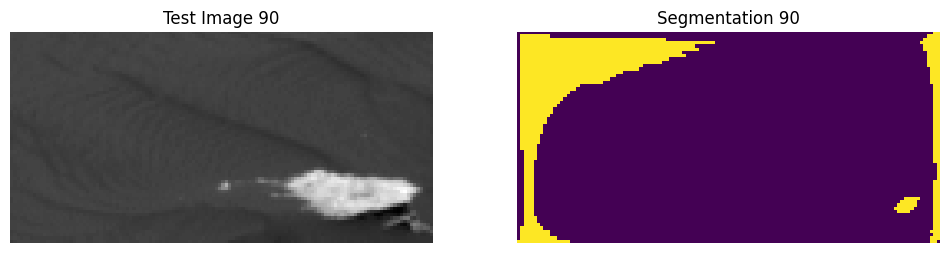

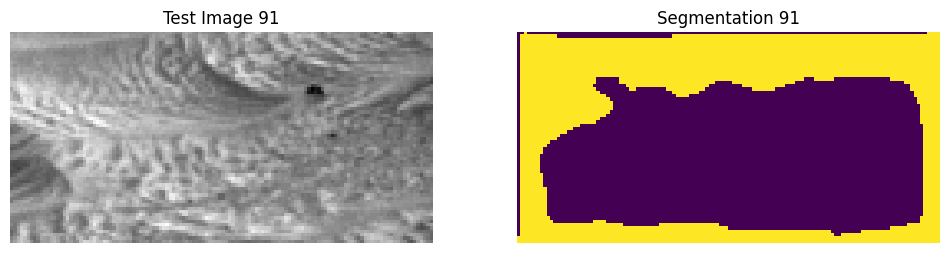

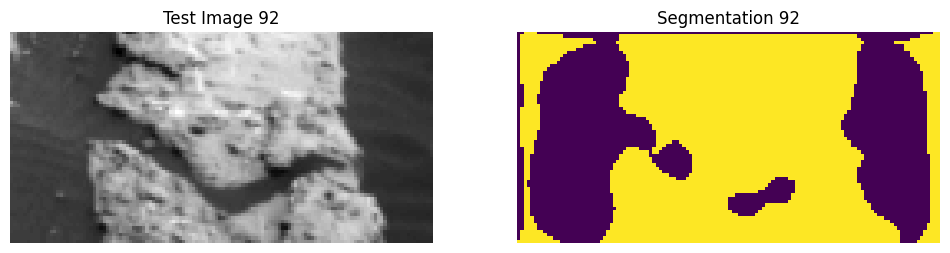

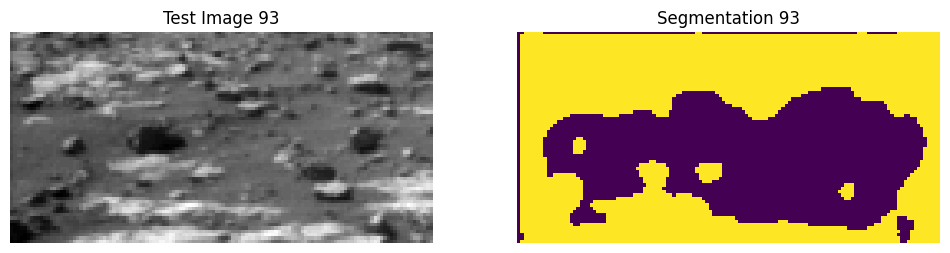

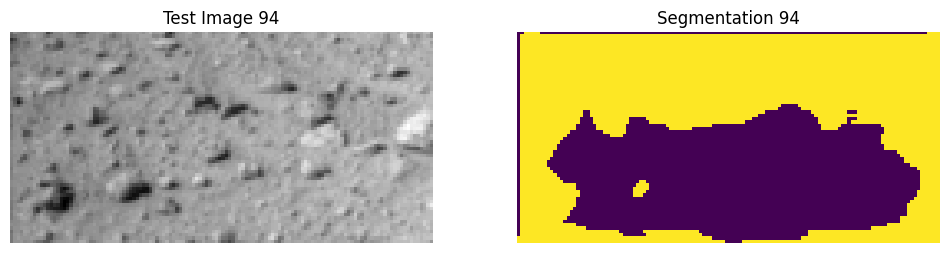

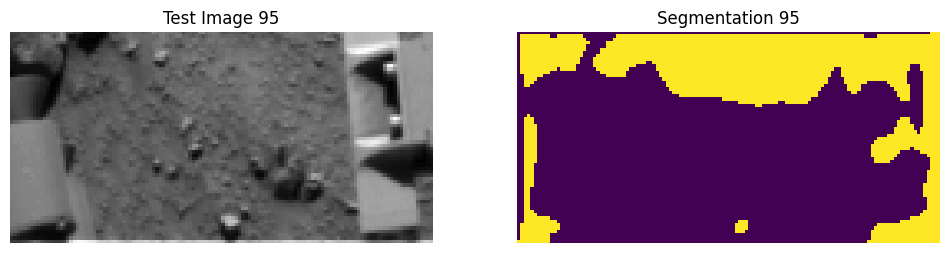

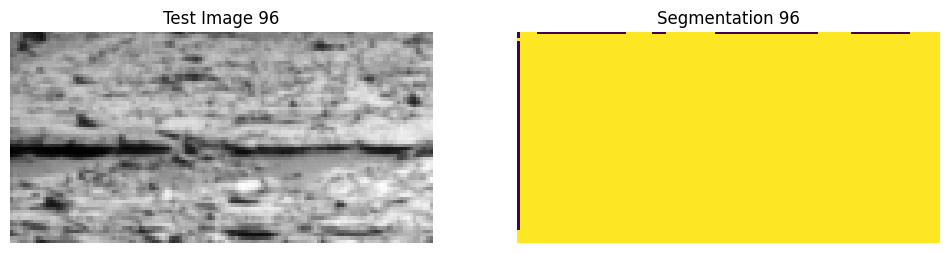

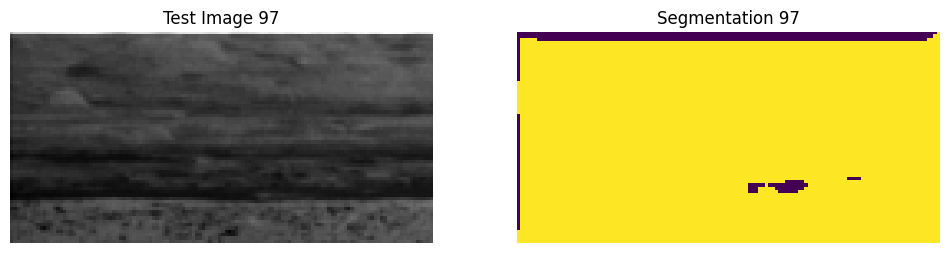

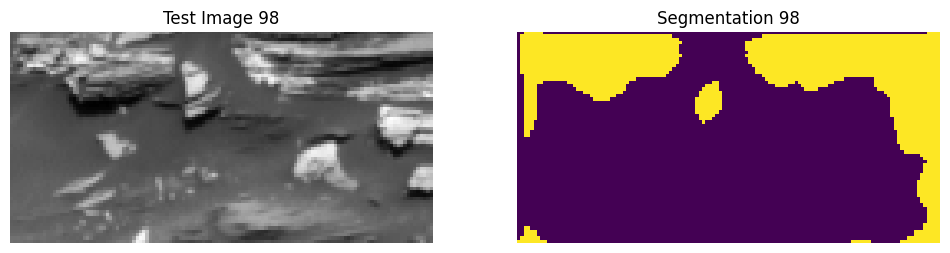

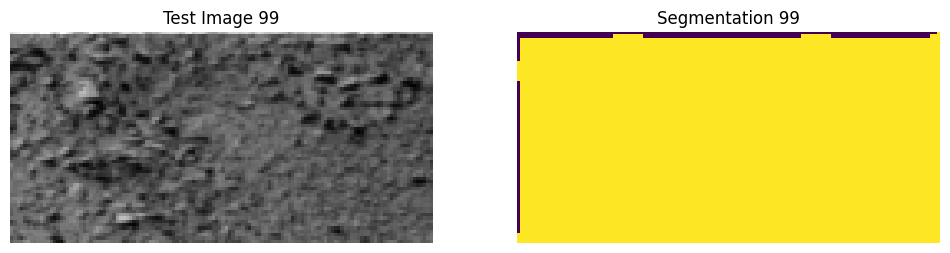

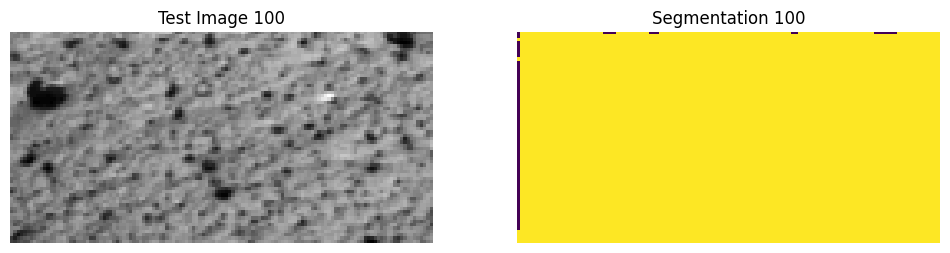

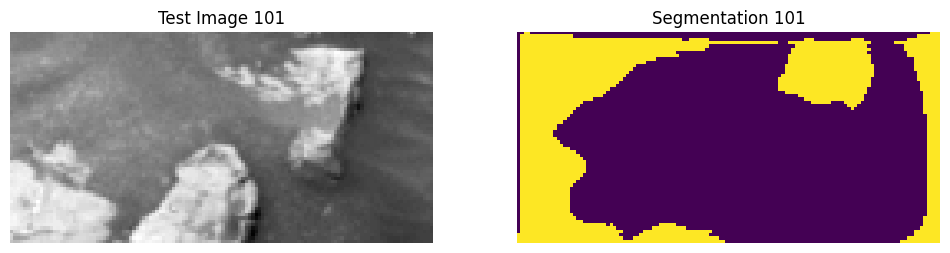

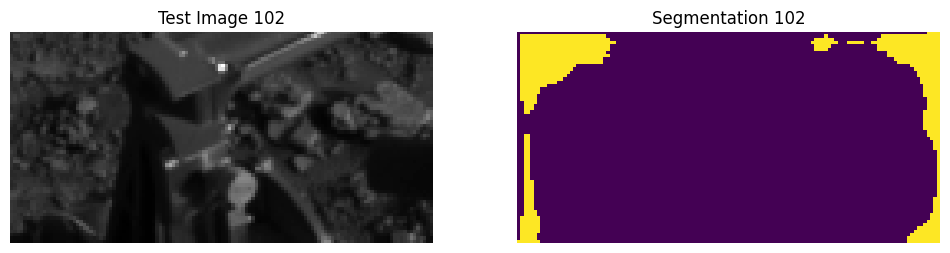

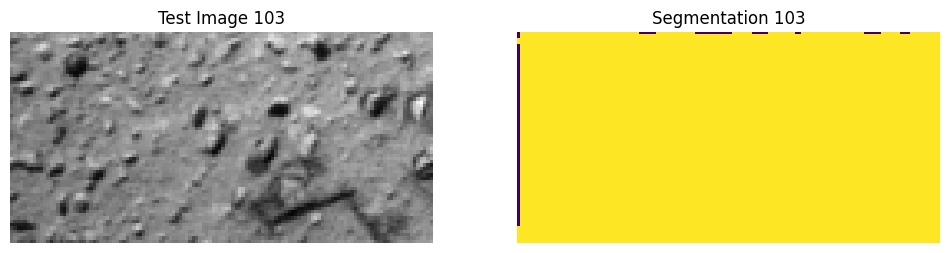

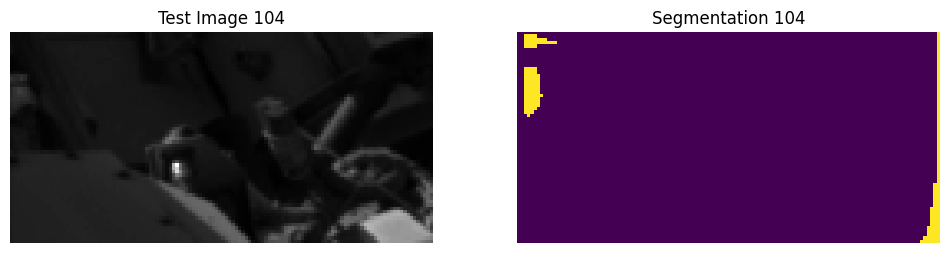

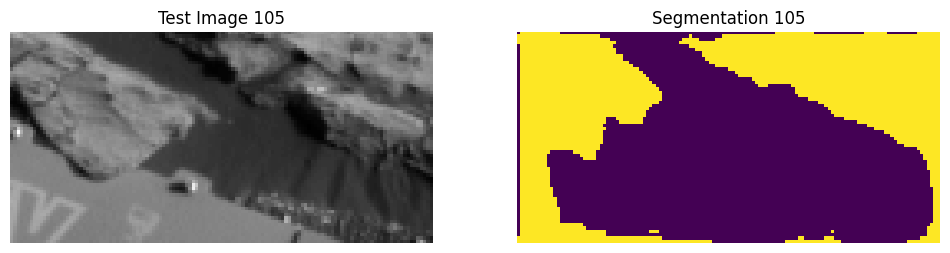

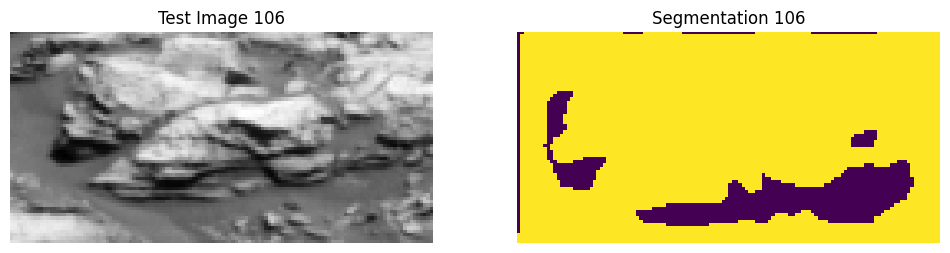

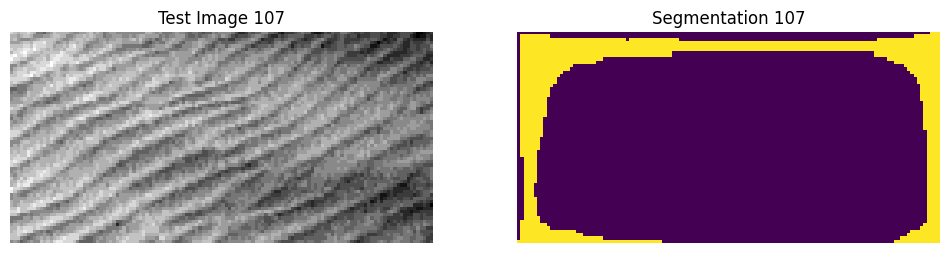

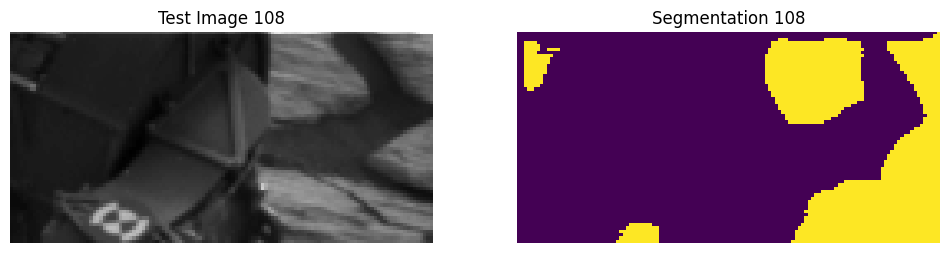

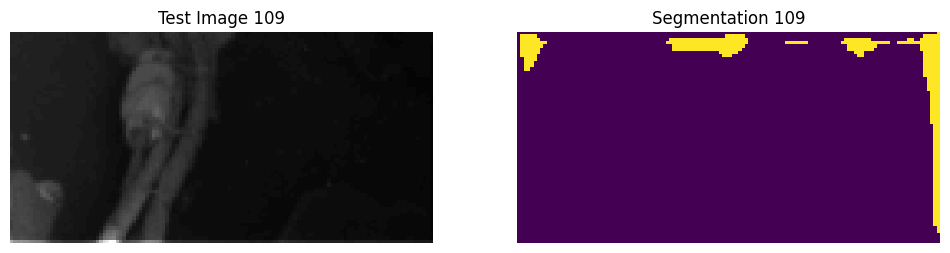

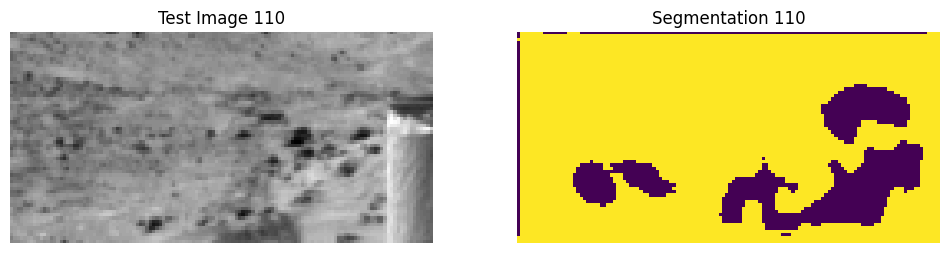

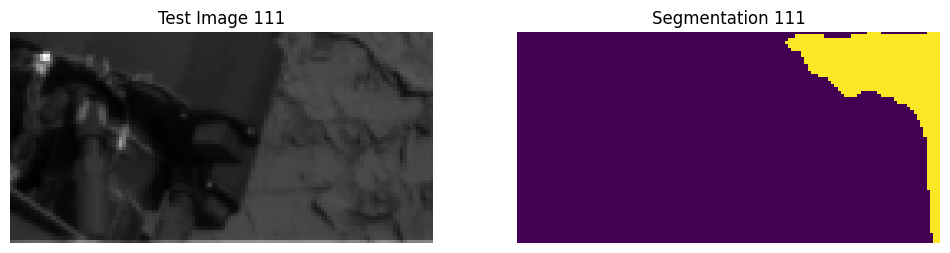

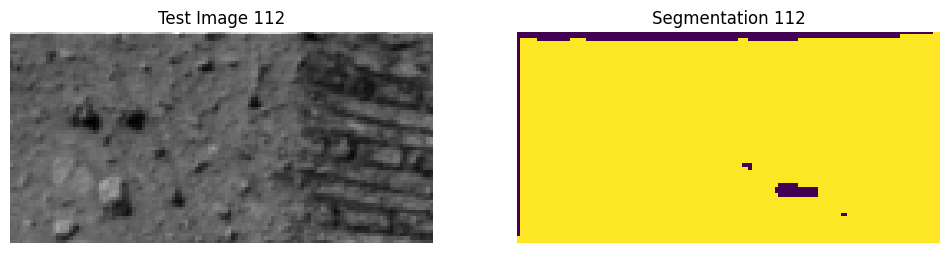

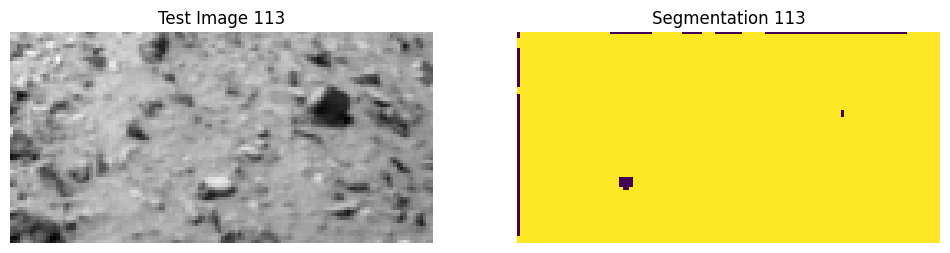

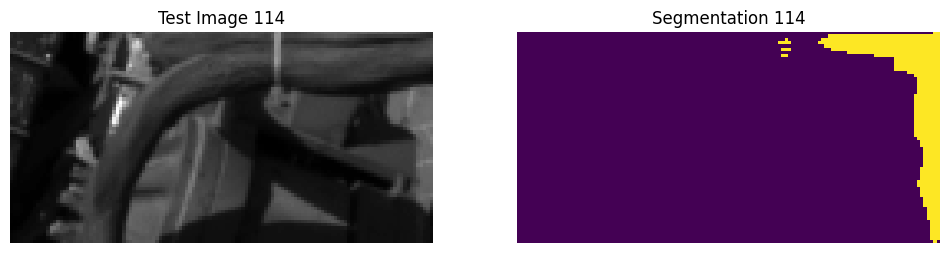

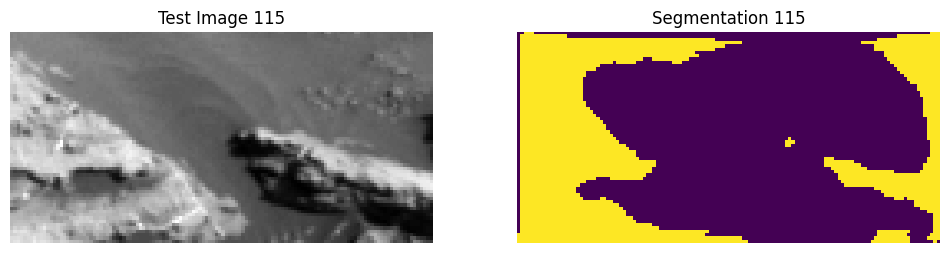

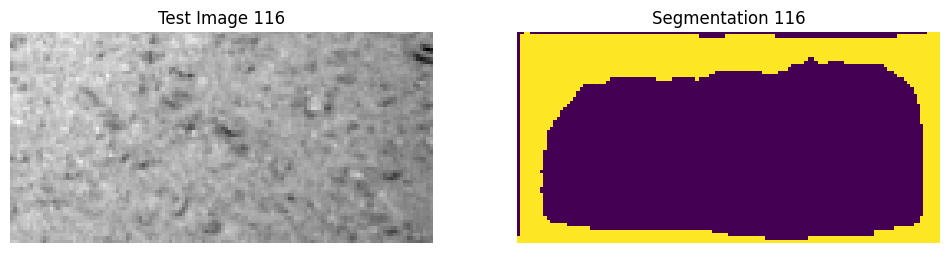

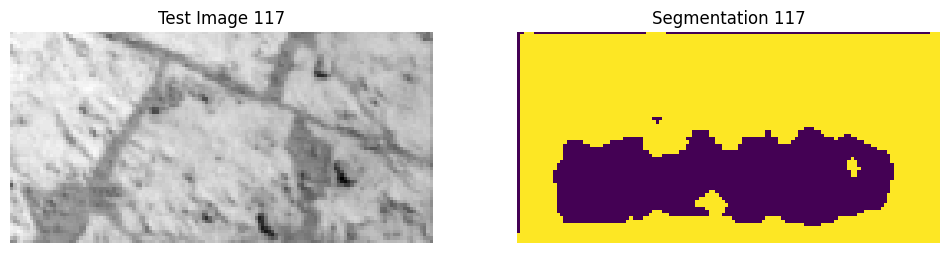

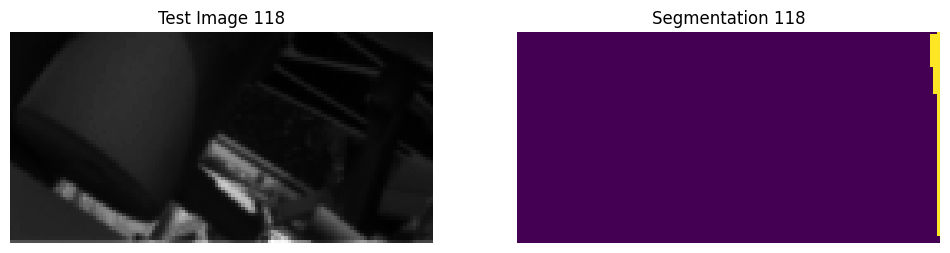

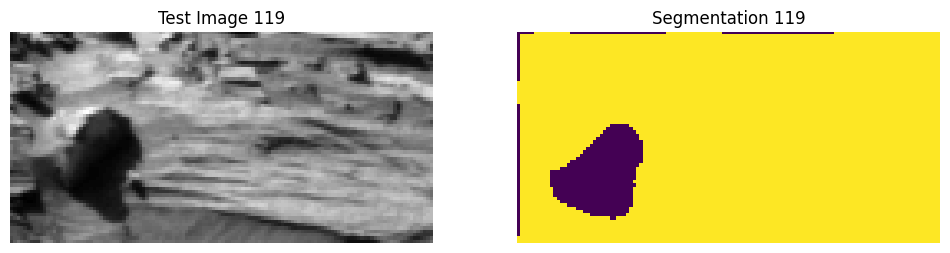

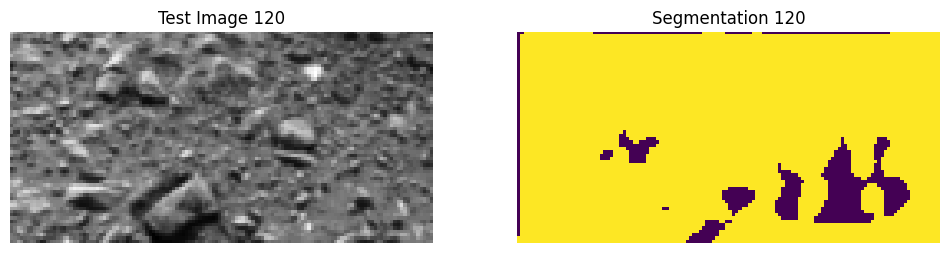

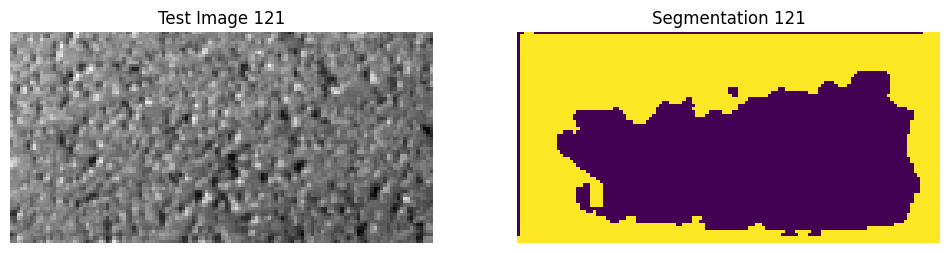

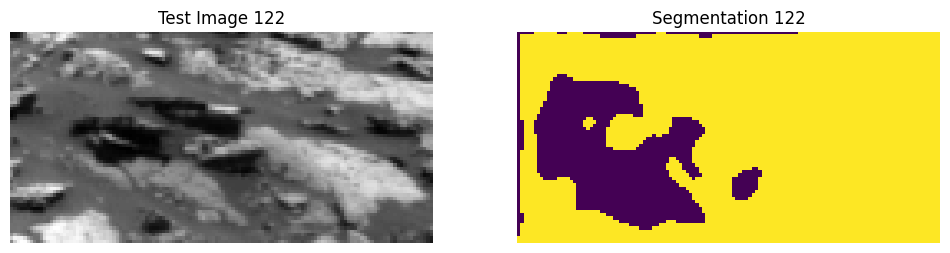

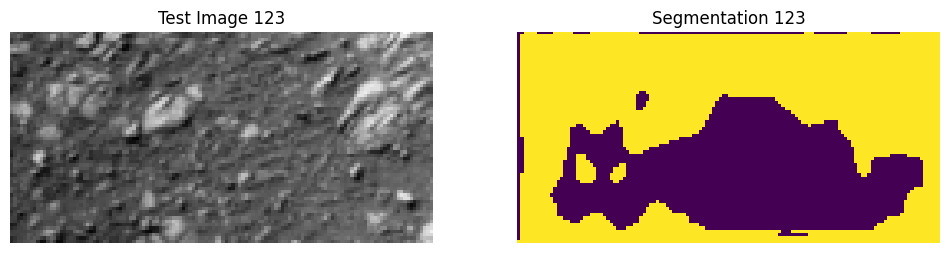

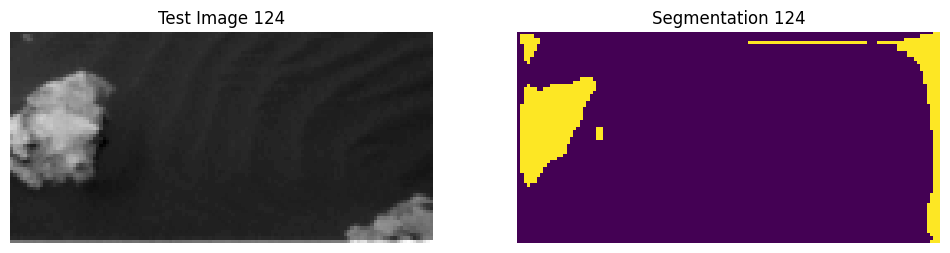

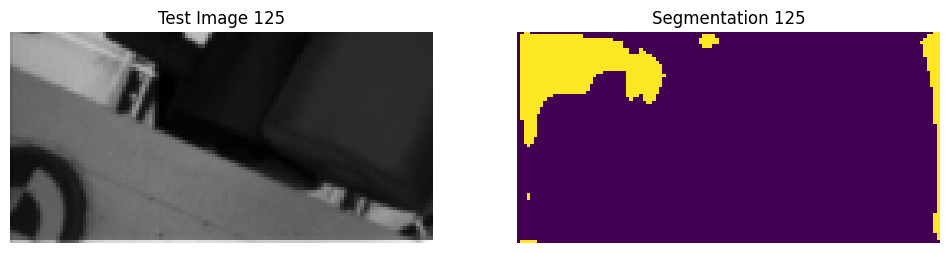

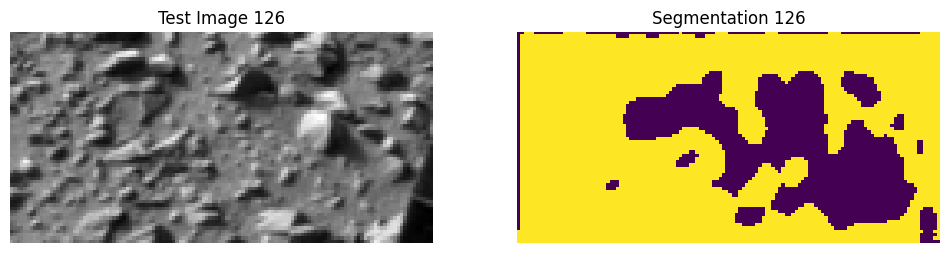

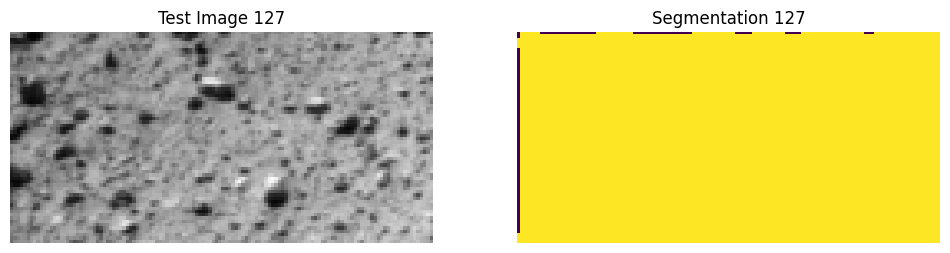

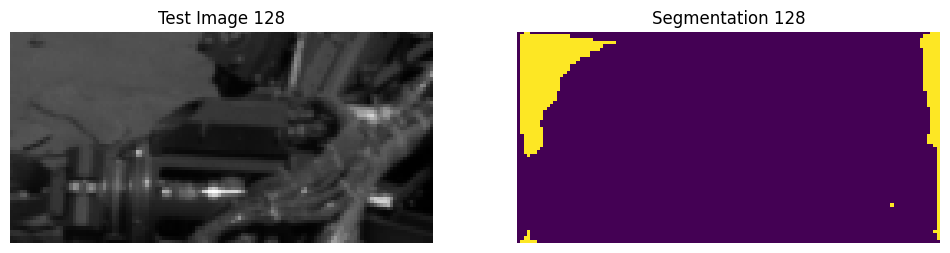

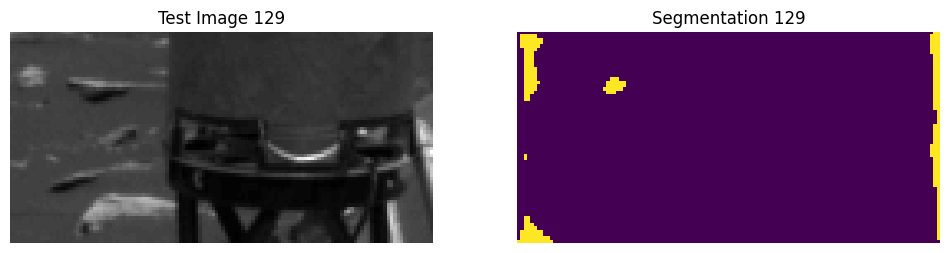

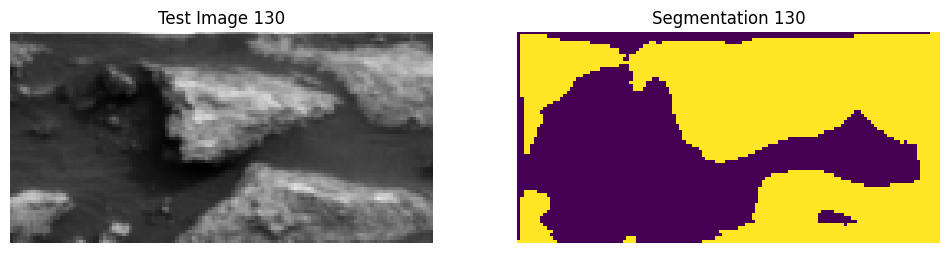

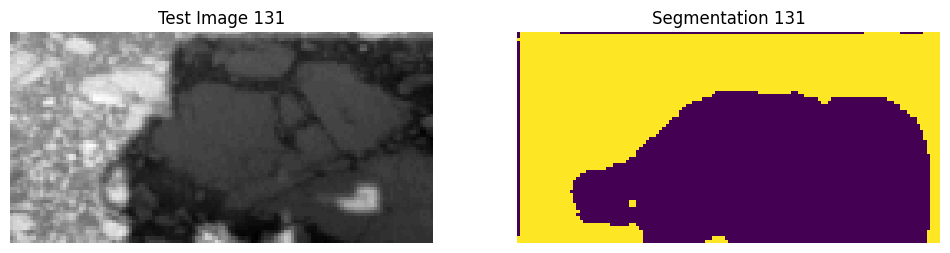

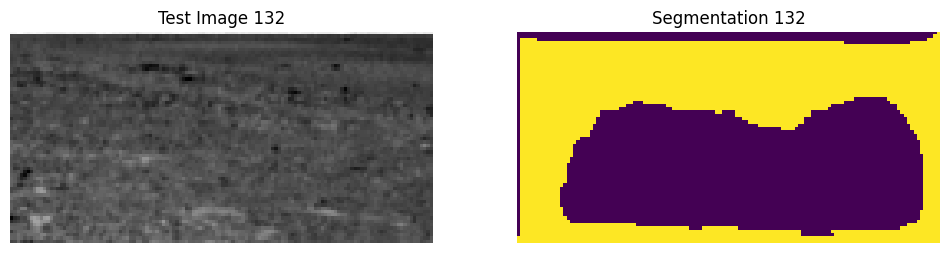

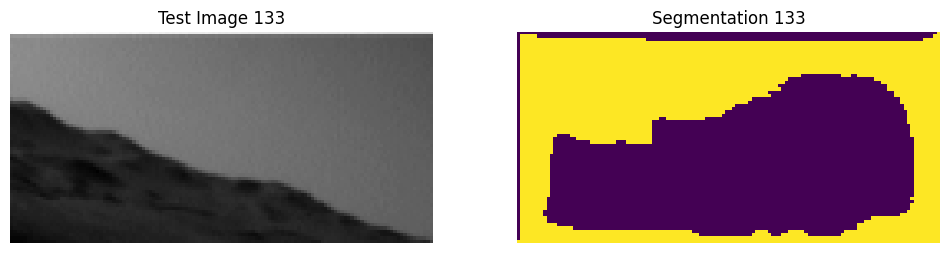

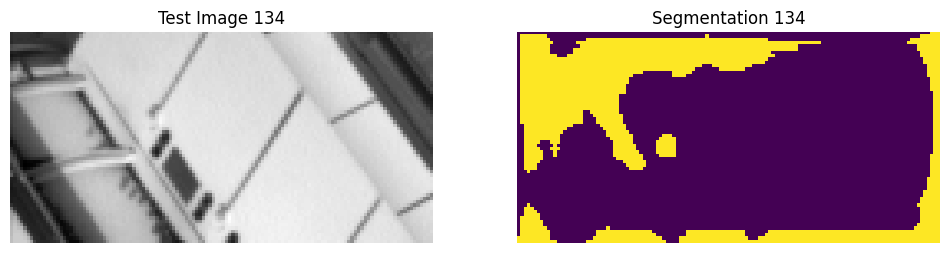

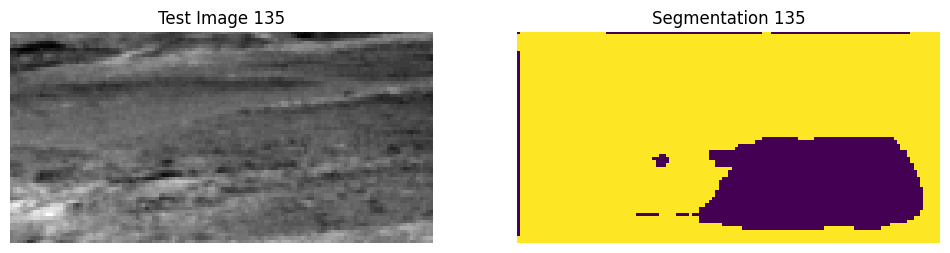

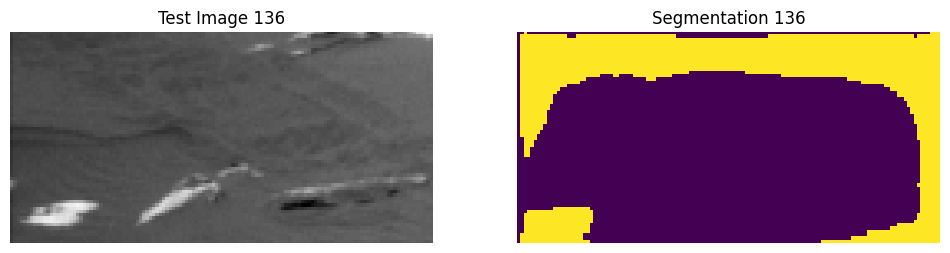

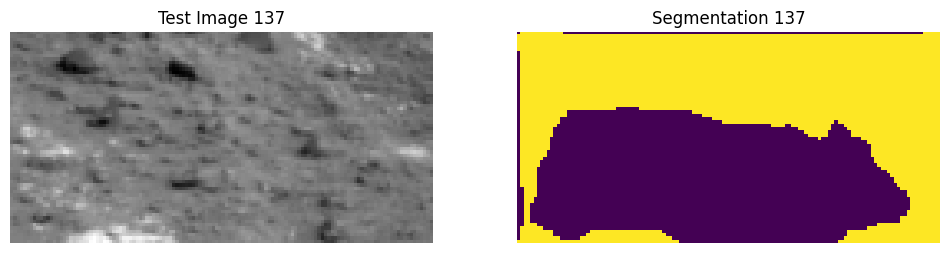

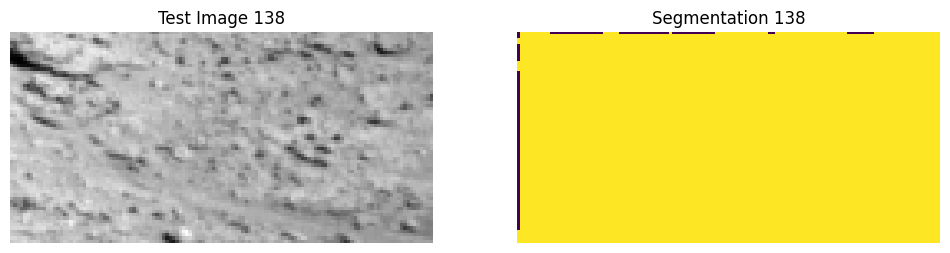

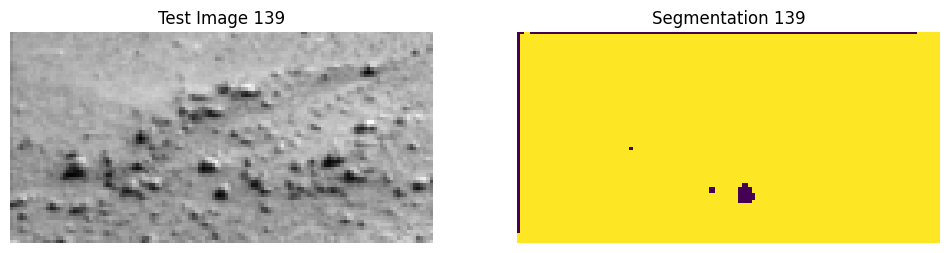

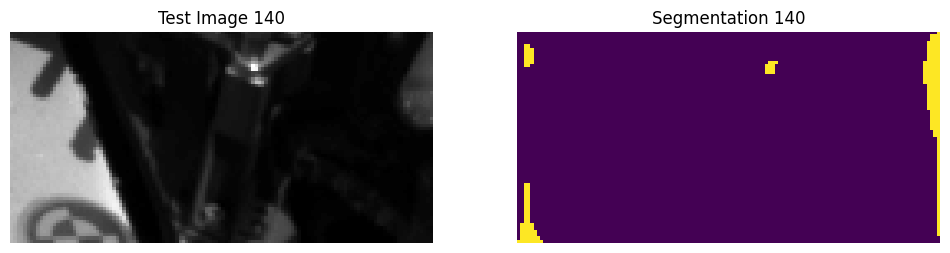

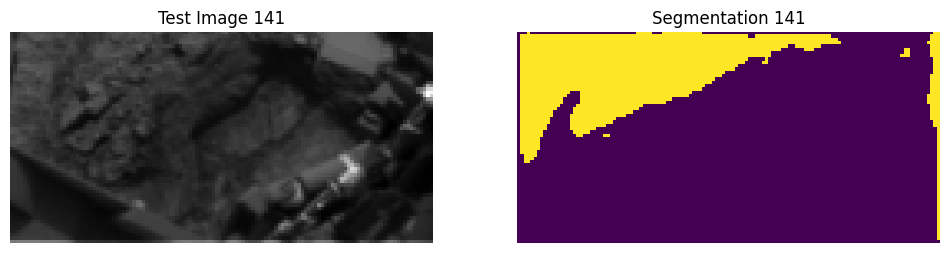

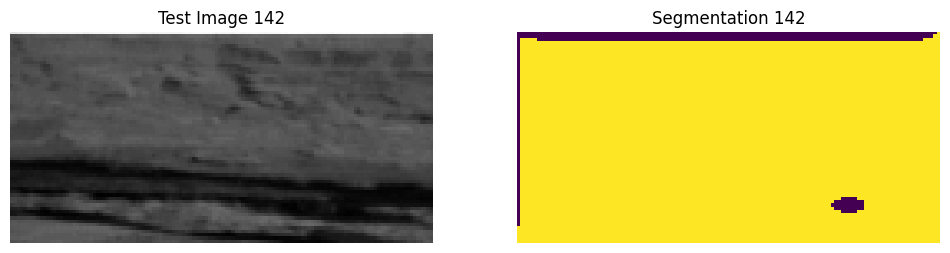

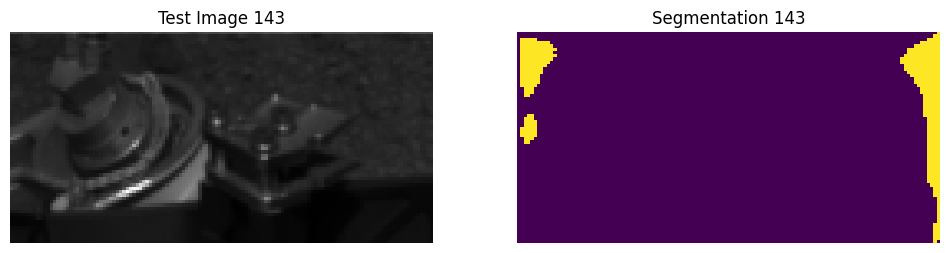

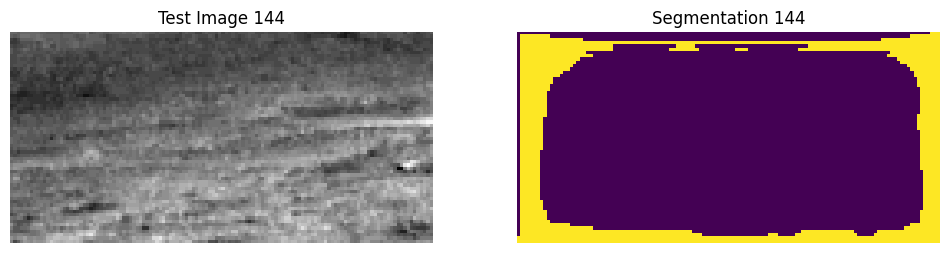

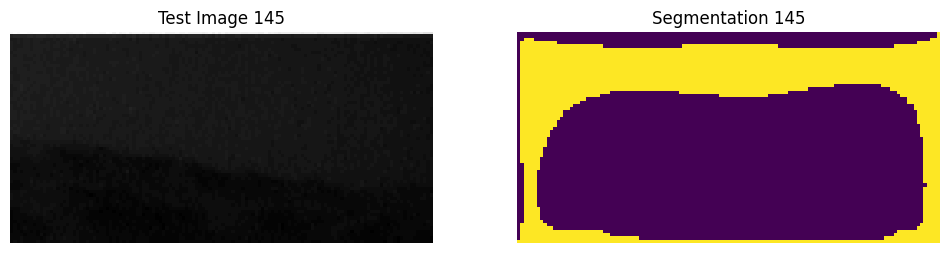

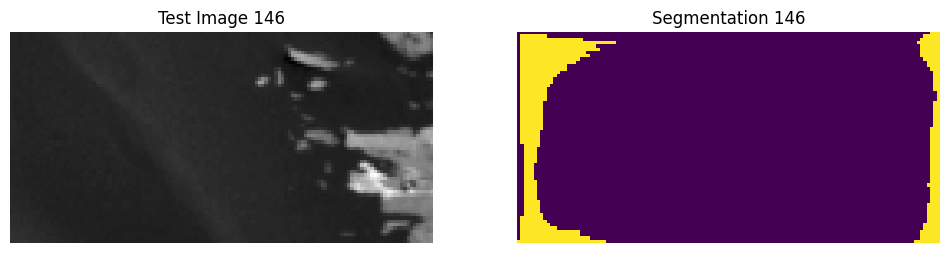

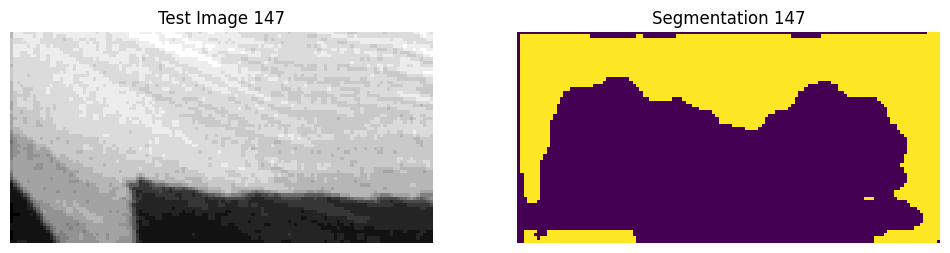

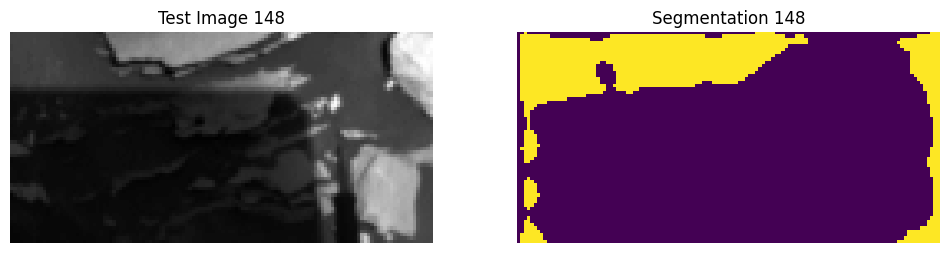

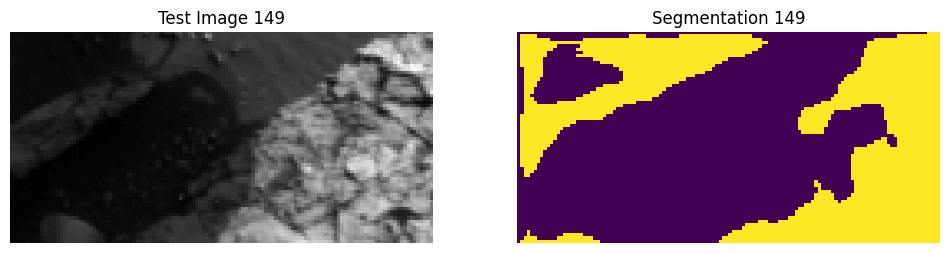

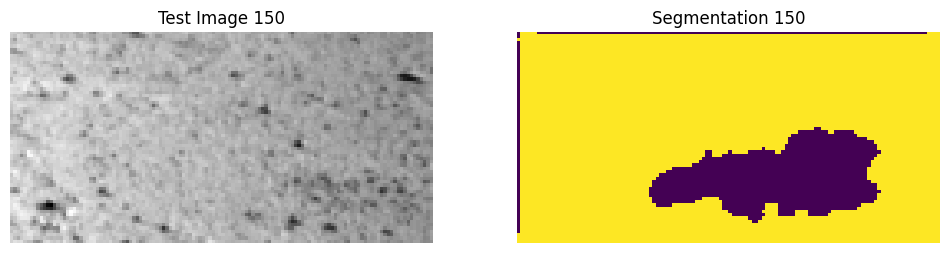

In [ ]:
"""
data = np.load("/kaggle/input/mars-for-students/mars_for_students.npz")
X_test = data["test_set"]
print(X_test.shape)

# Aggiungi il canale di profondità (grayscale)
X_test = np.expand_dims(X_test, axis=-1)  # Aggiunge la dimensione del canale
print("Test set shape after adding channel:", X_test.shape)

# Carica il modello salvato
model = tf.keras.models.load_model("/kaggle/working/UNet_.keras")

# Previsione sul test set
predictions = model.predict(X_test, verbose=1)  # Output sarà (10022, 64, 128, num_classes)
print("Predictions shape:", predictions.shape)

# Conversione delle predizioni in classi (argmax)
y_pred = np.argmax(predictions, axis=-1)  # Output sarà (10022, 64, 128)
print("Predictions after argmax shape:", y_pred.shape)

predictions = model.predict(X_test, verbose=1)
y_pred = np.argmax(predictions, axis=-1)  # Converte in classi


# Funzioni per la visualizzazione
def create_segmentation_colormap(num_classes):
    """Crea una mappa di colori per la segmentazione."""
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(mask, colormap):
    """Applica la colormap a una maschera."""
    mask = mask.astype(int)  # Assicura che i valori siano interi
    return colormap[mask]

# Visualizza alcune immagini e relative segmentazioni
colormap = create_segmentation_colormap(num_classes=5)  # Usa il numero di classi del tuo modello
for i in range(150):  # Mostra i primi 5 esempi
    plt.figure(figsize=(12, 6))

    # Immagine di input
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i, :, :, 0], cmap="gray")  # Mostra in scala di grigi
    plt.title(f"Test Image {i+1}")
    plt.axis("off")

    # Segmentazione prodotta
    plt.subplot(1, 2, 2)
    segmented = apply_colormap(y_pred[i], colormap)
    plt.imshow(segmented)
    plt.title(f"Segmentation {i+1}")
    plt.axis("off")

    plt.show()
"""